# Start Results Visualization

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\carlv\AppData\Local\Temp\ipykernel_24356\3338272293.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Convexity

In [2]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty
from helpers.nucleolus.nucleolus import get_nucleolus

In [3]:
import scipy.optimize as opt

def get_nash_bargaining_solution(v: dict, players: list, bargaining_power={}) -> dict:
    """
    Nash bargaining solution for a coalition game.

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    bargaining_power (optional): bargaining power of each player
        {player -> float}
    """
    # start by extracting status quo point: value of single players
    status_quo = {p: v.get(frozenset({p})) for p in players}
    # add constraint: sum of values must be less than value of grand coalition
    grand_coalition = frozenset(players)
    total = v.get(grand_coalition, 0)
    # construct scipy optimization problem
    if not bargaining_power:
        bargaining_power = {p: 1 for p in players}
    def objective(x):
        prod = 1
        for i, p in enumerate(players):
            prod *= (x[i] - status_quo[p]) ** bargaining_power[p]
        return -prod  # negative for minimization

    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - total}]
    constraints += [{'type': 'ineq', 'fun': lambda x: x[i] - status_quo[p]} for i, p in enumerate(players)]
    result = opt.minimize(objective, x0=list(status_quo.values()), constraints=constraints)
    if not result.success:
        print("ERROR: Optimization failed.")
        raise ValueError("Optimization failed.")
    nash_values = {p: result.x[i] for i, p in enumerate(players)}
    return nash_values

In [4]:
def make_subcoalition_convex(df, players):
    new_df = pd.DataFrame(0, index=df.index, columns=df.columns)
    for idx, row in df.iterrows():
        # make subcoalitions at least value of individual players
        v = {frozenset(k): val for k, val in row.items()}
        v[frozenset()] = 0  # ensure empty set is zero
        if not is_convex_game(v, players):
            # print(f"Warning: Game for {idx} is not convex, adjusting values.")
            for coalition in powerset(players):
                if len(coalition)==len(players) or len(coalition)==0: continue
                coalition_fs = frozenset(coalition)
                for p in coalition:
                    single_fs = frozenset({p})
                    other_players = coalition_fs - single_fs
                    if coalition_fs in v and single_fs in v and other_players in v:
                        v[coalition_fs] = max(v[coalition_fs], v[single_fs] + v[other_players])
        # row = {tuple(k): val for k, val in v.items()}
        row = [val for k, val in v.items() if k != frozenset()]
        # remove empty set entry
        if () in row: del row[()]
        new_df.loc[idx] = row
    return new_df

In [5]:
def add_reward_mechanisms(df: pd.DataFrame, players: list,
                    add_LOO=False, add_nucleolus=True) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO and nucleolus.

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
        if add_nucleolus:
            new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo', '0. nucleolus']))
    df_new = pd.DataFrame(pd.NA, index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
        if add_nucleolus:
            is_core_empty = core_nonempty(v, players)
            if not is_core_empty:
                print(f"Core is empty for {idx}, skipping nucleolus computation.")
                continue
            try:
                nucleolus = get_nucleolus(v, players)
                df_new.loc[(idx, '0. nucleolus'), list((k,) for k in nucleolus.keys())] = list(nucleolus.values())
            except Exception as e:
                print(f"Error computing nucleolus for {idx}: {e}")
                # remove the nucleolus row
                # df_new = df_new.drop(index=(idx, 'nucleolus'))
    return df_new

In [6]:
def print_2f_dict(d: dict):
    final_print = ''
    for k, v in d.items():
        final_print += f"{k}: {v:.2f}, "
    return final_print

In [7]:
players = ['A', 'B', 'C']
v = {
    (): 0,
    ('A',): 0,
    ('B',): 0,
    ('C',): 0,
    ('A', 'B'): 100,
    ('A', 'C'): 0,
    ('B', 'C'): 0,
    ('A', 'B', 'C'): 200
}
# convert v to frozenset
v_frozen = {frozenset(k): val for k, val in v.items()}

In [8]:
# test
is_convex_game(v_frozen, players)
core_nonempty(v_frozen, players)
print("LOO: ", get_loo(v_frozen, players, normalized=False))
print("Shapley: ", print_2f_dict(get_shapley_value(v_frozen, players)))
print("NBS :", print_2f_dict(get_nash_bargaining_solution(v_frozen, players)))
print("Banzhaf: ", print_2f_dict(get_banzhaf_value(v_frozen, players)))
print("Nucleolus: ", print_2f_dict(get_nucleolus(v_frozen, players)))

Core is non-empty, one feasible allocation: [200.   0.   0.]
LOO:  {'A': 200, 'B': 200, 'C': 100}
Shapley:  A: 83.33, B: 83.33, C: 33.33, 
NBS : A: 66.67, B: 66.67, C: 66.67, 
Banzhaf:  A: 85.71, B: 85.71, C: 28.57, 
Nucleolus:  A: 75.00, B: 75.00, C: 50.00, 


## Define Plot Function

In [9]:
import matplotlib as mpl

In [10]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_24356\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [11]:
def visualize_value_results(df_new, df_newstat, calc_convexity=True,
                            pf_names=['DPF', 'SPF']):
    players = list(str(x[0]) for x in [col for col in df_new.columns if len(col)==1])
    # plot for each service value, shapely and nbs
    for service in df_new.index.get_level_values(0).unique():
        df_plot = df_new.loc[service]
        # drop index rows that are all NaN
        df_plot = df_plot.dropna(axis=0, how='all')
        df_plot = df_plot.transpose()
        df_plot.columns = [col + ' ' + pf_names[0] for col in df_plot.columns]
        # also add df_newstat values
        if df_newstat is not None:
            df_plot_stat = df_newstat.loc[service]
            df_plot_stat = df_plot_stat.dropna(axis=0, how='all')
            df_plot_stat = df_plot_stat.transpose()
            # remove value column as it is duplicate
            # df_plot_stat = df_plot_stat.loc[:, df_plot_stat.columns != 'value']
            df_plot_stat.columns = [col + ' ' + pf_names[1] for col in df_plot_stat.columns]
            # combine
            df_plot_total = pd.concat([df_plot, df_plot_stat], axis=1)
        else:
            df_plot_total = df_plot
        df_plot_total = df_plot_total.reindex(sorted(df_plot_total.columns, reverse=True), axis=1)
        # 1st plot: only the players
        df_plot = df_plot_total.iloc[:len(players)]

        plt.figure()

        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Individual Value, Shapley and NBS', ylabel='Value in €')
        
        
        plt.grid()
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()*1.2)
        plt.legend(loc='upper left')
        plt.show()

        # 2nd plot: all coalitions
        plt.figure()
        # drop na columns
        df_plot = df_plot_total.dropna(axis=1, how='any')
        # add two new index rows: Grand-C Convex Game? and Convex Game?

        # add convexity where there is  empty coalition
        if calc_convexity:
            df_plot = pd.concat([df_plot, pd.DataFrame(0, index=['Core non-empty?', 'Convex Game?'], columns=df_plot.columns)], axis=0)
            v1 = {frozenset(k): val for k, val in df_new.loc[service].loc['value'].items()}
            v1[frozenset()] = 0  # ensure empty coalition is present
            if df_newstat is not None:
                v2 = {frozenset(k): val for k, val in df_newstat.loc[service].loc['value'].items()}
                v2[frozenset()] = 0  # ensure empty coalition is present
                # create df and append
                df_plot.loc['Core non-empty?', 'value ' + pf_names[1]] = float(core_nonempty(v2, players))
                df_plot.loc['Convex Game?', 'value ' + pf_names[1]] = float(is_convex_game(v2, players))

            df_plot.loc['Core non-empty?', 'value ' + pf_names[0]] = float(core_nonempty(v1, players))
            df_plot.loc['Convex Game?', 'value ' + pf_names[0]] = float(is_convex_game(v1, players))
            
        
        
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Value of Coalitions', ylabel='Value in €')
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()*1.2)
        plt.show()


## DVPP1

no stochastic production, just 1MW of PV, Wind, BESS each

**IO_dict =      {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }**

In [15]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
n_players = 3
df = pd.read_csv('pics/v1/values_dyn.csv', index_col=0, header=list(range(n_players)))
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = list(str(x[0]) for x in df.columns[:n_players])

df.dropna(inplace=True)
df = df.astype(float)
df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,12.37032,12.37032,24.74064
FFR,1.13156,0.89878,4.66527,2.03035,5.73864,5.59315,6.60833
FFR-FCR,4.73210,3.80625,0.00000,8.07543,11.67593,11.90740,23.81479
FCR-D,12.60178,12.60178,0.00000,25.20356,12.60178,12.60178,25.20356


In [41]:
# also load static pf values
dfstat = pd.read_csv('pics/v1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,6.12086,6.12086,16.40803
FFR,1.13156,0.89878,4.66527,2.03035,5.01121,4.86572,5.79360
FFR-FCR,4.73210,3.80625,0.00000,8.53835,6.12086,6.12086,16.40803
FCR-D,12.60178,12.60178,0.00000,25.20356,7.27817,7.27817,19.18557


In [42]:
print('Computing Reward Mechanisms for Dynamic')
df_new = add_reward_mechanisms(df, players, add_LOO=True)
print('Computing Reward Mechanisms for Static')
df_newstat = add_reward_mechanisms(dfstat, players, add_LOO=True)

Computing Reward Mechanisms for Dynamic
Core is non-empty, one feasible allocation: [12.37032 12.37032  0.     ]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [11.90739 11.9074   0.     ]
Core is non-empty, one feasible allocation: [12.60178 12.60178  0.     ]
Computing Reward Mechanisms for Static
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [10.28717  6.12086  0.     ]
Core is empty for FCR-D, skipping nucleolus computation.


In [43]:
df_v1 = df_new.copy()
df_v1stat = df_newstat.copy()

<Figure size 640x480 with 0 Axes>

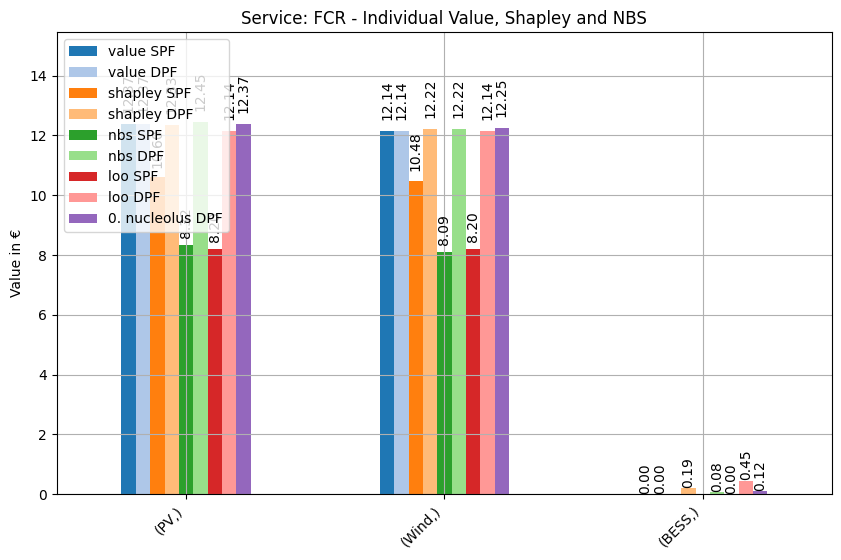

Core is non-empty, one feasible allocation: [12.37032 12.37032  0.     ]


<Figure size 640x480 with 0 Axes>

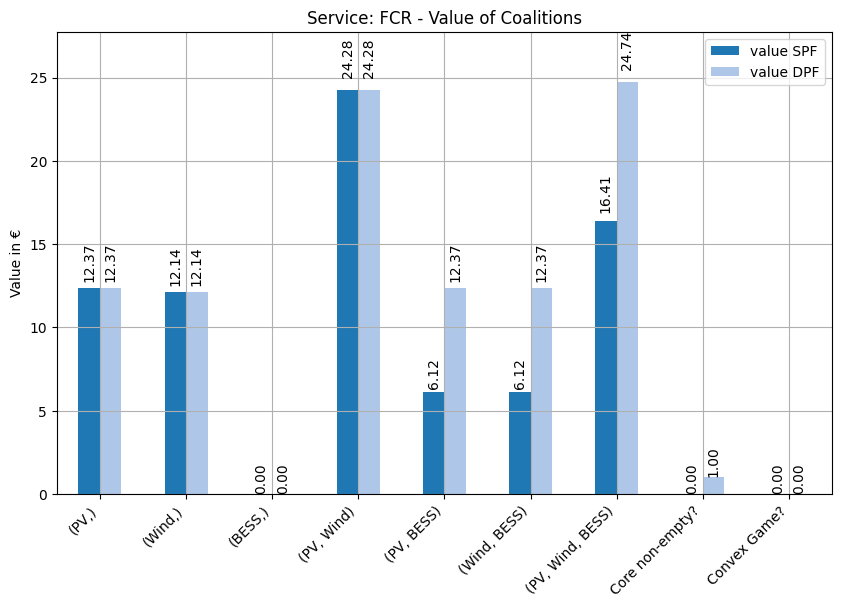

<Figure size 640x480 with 0 Axes>

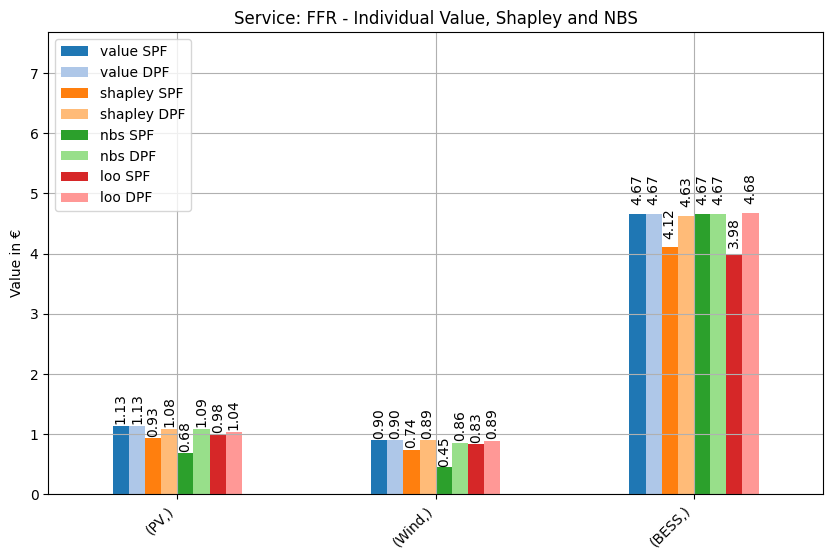

<Figure size 640x480 with 0 Axes>

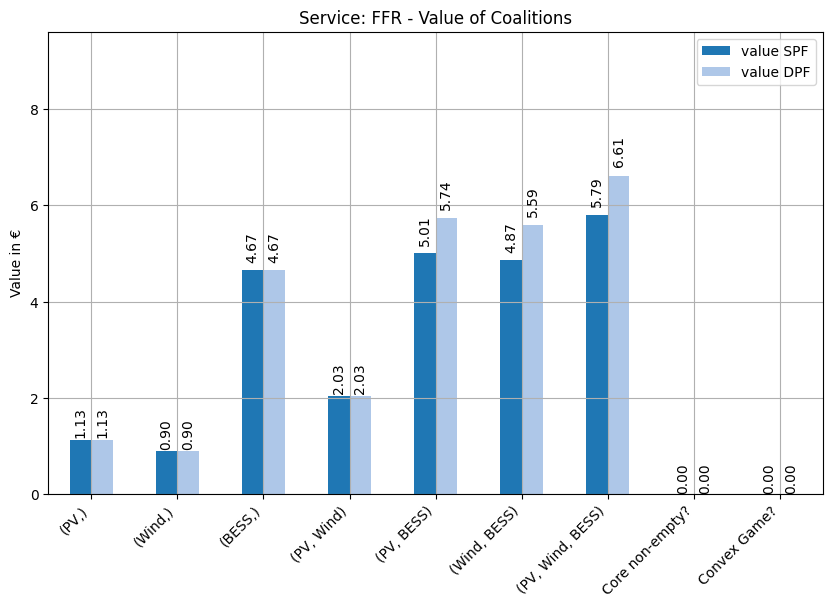

<Figure size 640x480 with 0 Axes>

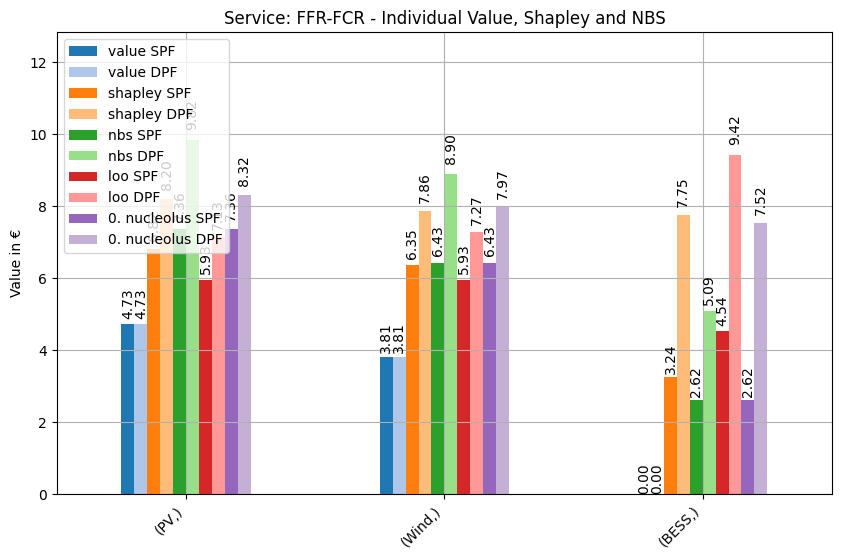

Core is non-empty, one feasible allocation: [10.28717  6.12086  0.     ]
Core is non-empty, one feasible allocation: [11.90739 11.9074   0.     ]


<Figure size 640x480 with 0 Axes>

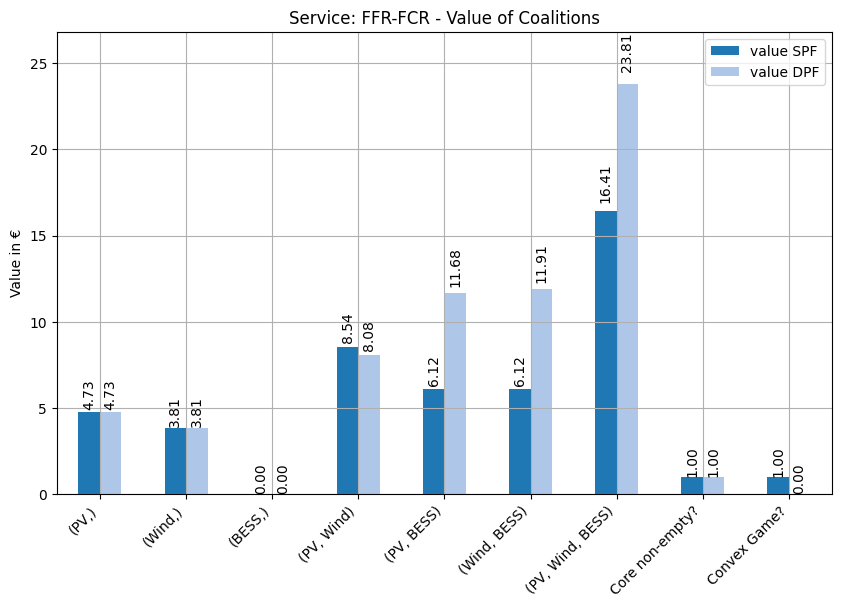

<Figure size 640x480 with 0 Axes>

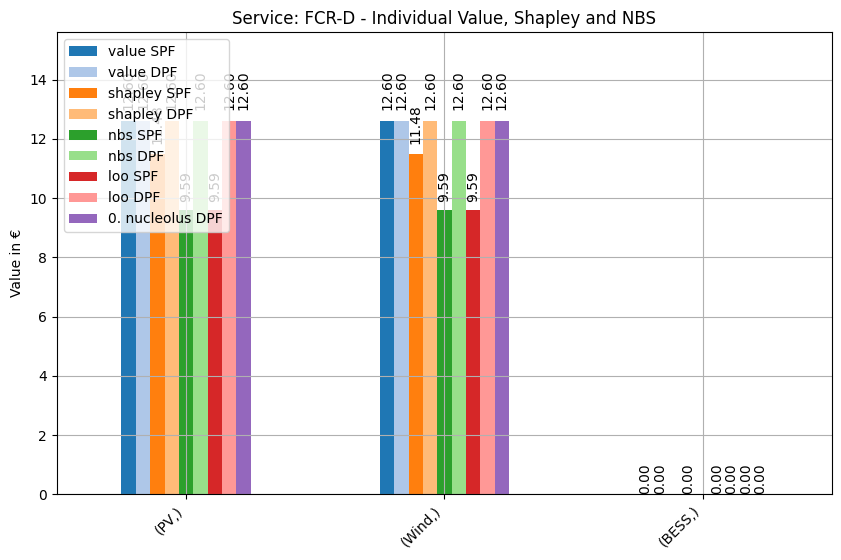

Core is non-empty, one feasible allocation: [12.60178 12.60178  0.     ]


<Figure size 640x480 with 0 Axes>

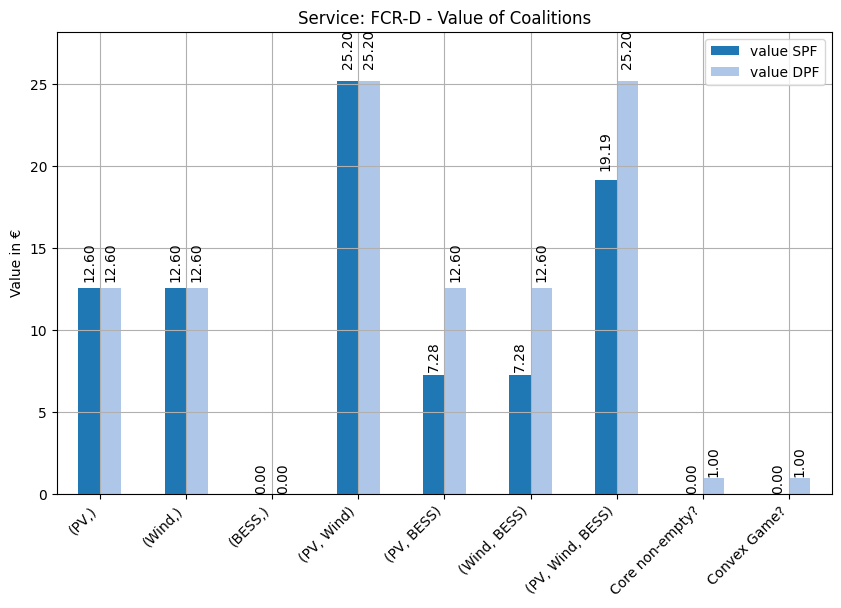

In [44]:
visualize_value_results(df_new, df_newstat)

## DVPP2

stochastic production of PV, BESS Wind with 

IO_dict =      {'PV': (get_pv_sys(), 'lpf', 2),
                'Wind': (get_wind_sys(), 'lpf', 1.5),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }

In [45]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v2/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

# df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

# df_mean = df.groupby('Service').mean() # probably this line causes the trouble

(PV,)   (Wind,)   (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                         
FCR     0         14.48415  12.04186  16.31587    25.78414    30.11433   
        1          5.71954   3.90542   6.05969     9.48239    11.57989   
        2         -1.60398   4.46278   5.24840     4.46278     5.25008   
        3          5.43981   6.18612   7.97728    11.25268    13.09880   
        4          1.51016   2.75281   4.15080     4.23029     5.69797   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0             27.69097          41.79472  
        1              9.79512          15.42870  
        2              9.54280           9.54445  
        3             13.80991          19.08070  
        4              6.78520           8.30342

In [46]:
all_scenarios = []
for sc in df.index.get_level_values(1).unique():
    scenario_df = df.xs(sc, level='Scenario')
    scenario_df = make_subcoalition_convex(scenario_df, players)
    # compute reward mechanisms
    # scenario_df_new = add_reward_mechanisms(scenario_df, players, add_LOO=True)
    all_scenarios.append(scenario_df)
# now mean over all scnenarios
df_new = pd.concat(all_scenarios).groupby(level=0).mean()

C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.48415' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.04186' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\2593672234.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '16.31587' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[idx] = row
C:\Users\carlv\AppData\Local\Temp\ipykernel_22

In [47]:
df_final = add_reward_mechanisms(df_new, players, add_LOO=True)

Core is empty for FCR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [4.601401 6.321701 8.364902]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [1.619858 1.990264 7.970039]


In [48]:
# df_final = all_scenarios[0]
# for df in all_scenarios[1:]:
#     df_final = df_final.add(df, fill_value=0)
# df_final = df_final / len(all_scenarios)
# df_final

In [49]:
# # also load static pf values
# dfstat = pd.read_csv('pics/v2/values_stat.csv', index_col=0, header=[0,1,2])
# dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
# players = list(dfstat.columns[-2])
# dfstat[dfstat < 0] = 0  # set values below zero to zero
# # combine 1st col and index to MultiIndex
# dfstat.index = pd.MultiIndex.from_arrays([dfstat.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
# dfstat.drop(dfstat.columns[0], axis=1, inplace=True)  # drop first column
# players = list(str(x[0]) for x in dfstat.columns[:3])

# dfstst_mean = dfstat.groupby(level=0).mean()

In [50]:
# df_new = add_reward_mechanisms(df_mean, players, add_LOO=True)
# todo: run static
# df_newstat = add_reward_mechanisms(dfstst_mean, players, add_LOO=True)

In [51]:
df_v2 = df_final.copy()
# df_v2stat = df_newstat.copy()

<Figure size 640x480 with 0 Axes>

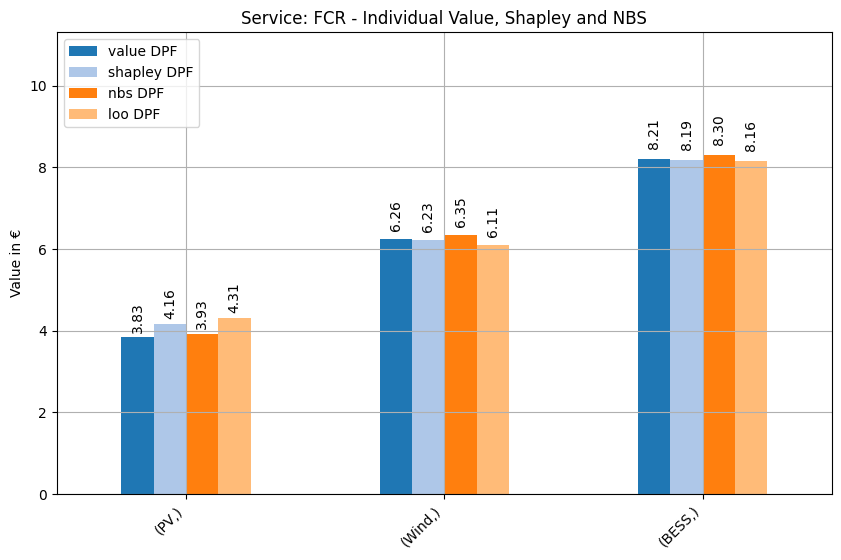

<Figure size 640x480 with 0 Axes>

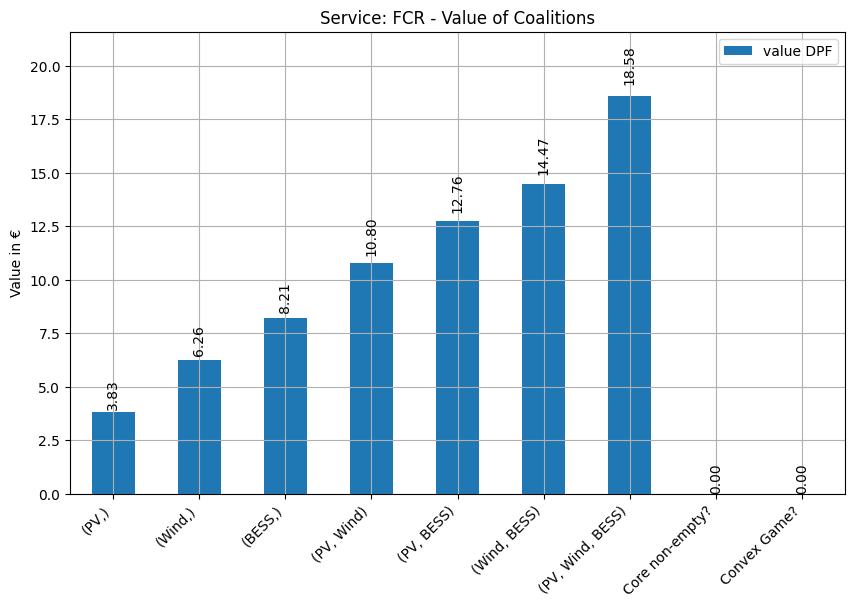

<Figure size 640x480 with 0 Axes>

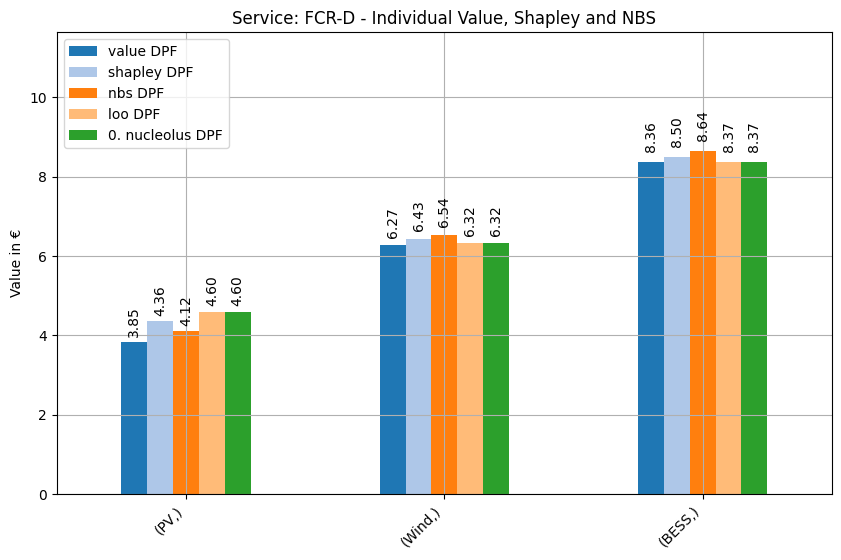

Core is non-empty, one feasible allocation: [4.601401 6.321701 8.364902]


<Figure size 640x480 with 0 Axes>

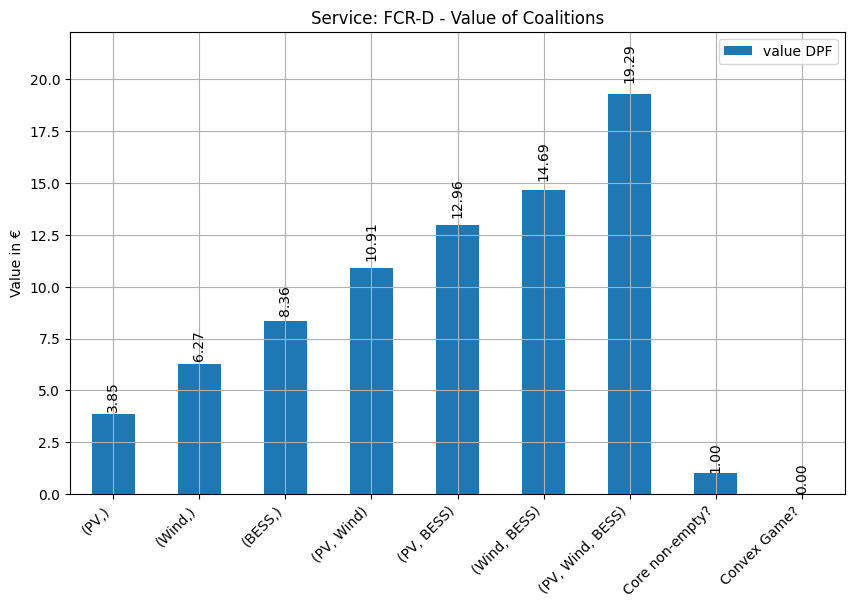

<Figure size 640x480 with 0 Axes>

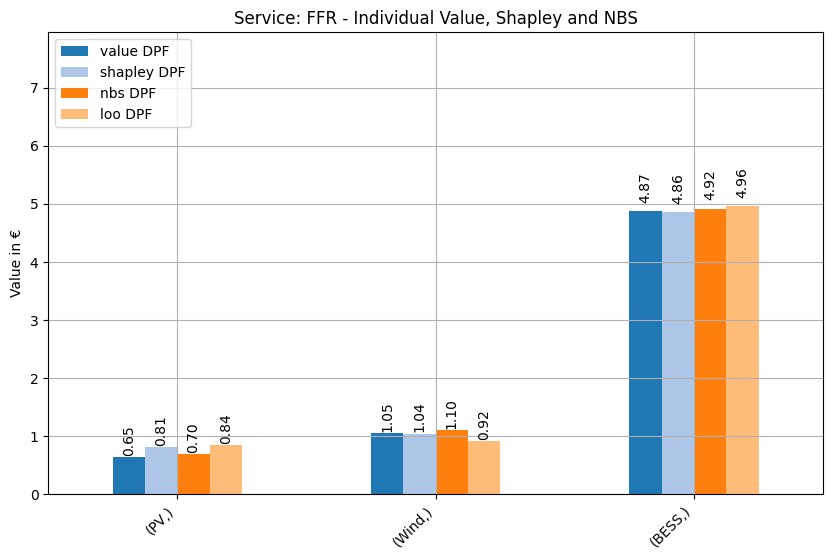

<Figure size 640x480 with 0 Axes>

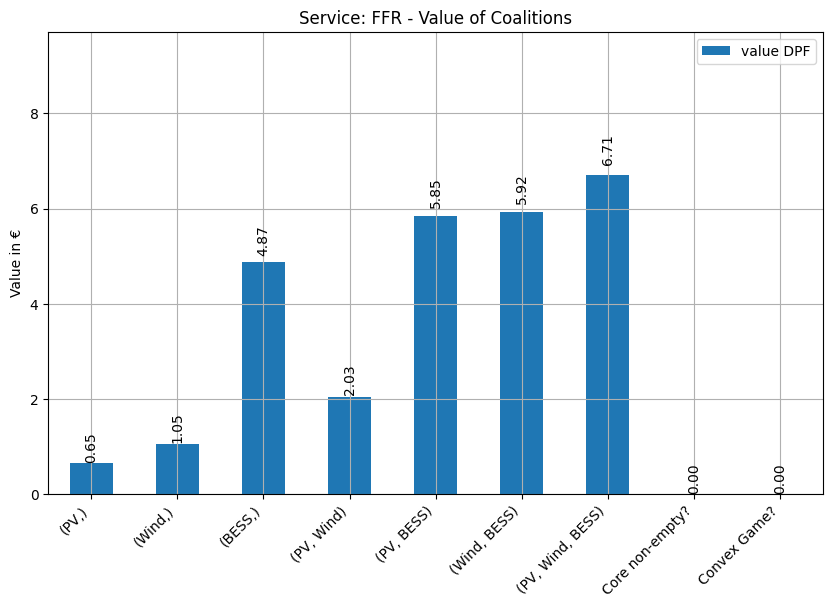

<Figure size 640x480 with 0 Axes>

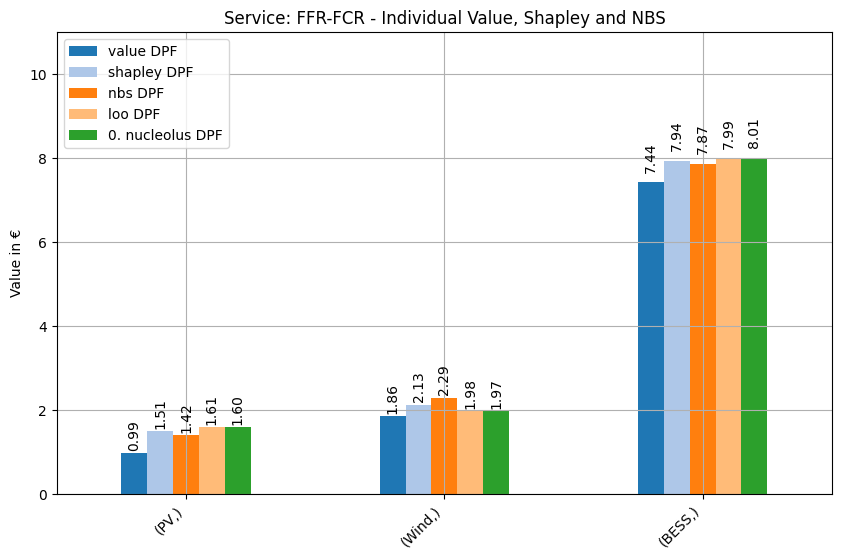

Core is non-empty, one feasible allocation: [1.619858 1.990264 7.970039]


<Figure size 640x480 with 0 Axes>

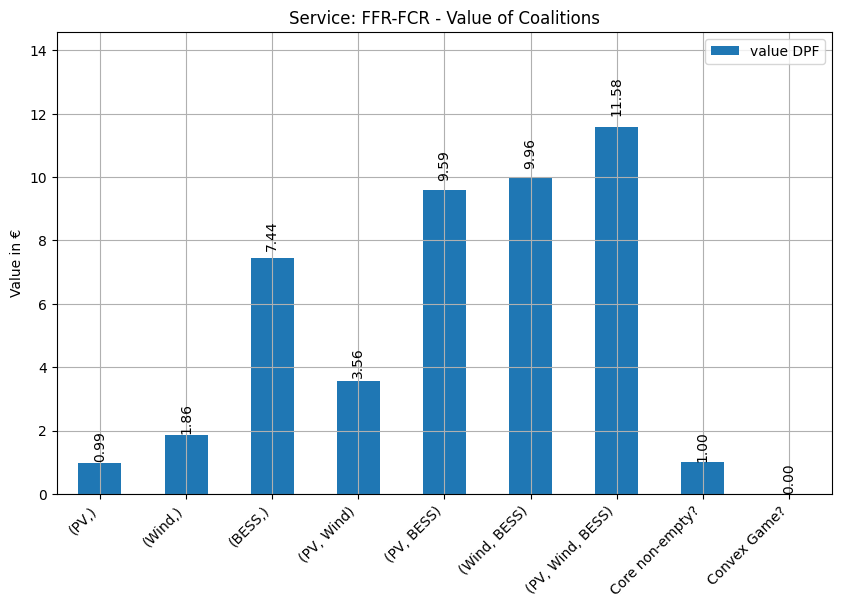

In [52]:
# visualize:
visualize_value_results(df_final, None)

## DVPP Hydro-Bess-SC

no stochastic production, 1MW of

**IO_dict = {'Hydro': (get_hydro_tf(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                'SC': (get_sc_io_sys(t_drop=5), 'hpf', 1),
                }**

In [53]:
# load data
df = pd.read_csv('pics/vh1/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = [str(x[0]) for x in df.columns[:3]]
df[df < 0] = 0  # set values below zero to zero
df

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,9.18130,3.27903,0.00000,9.18130
FFR,0.0,3.16838,0.60781,2.97439,0.00000,3.80205,3.21235
FFR-FCR,0.0,0.00000,0.00000,9.52849,0.00000,0.00000,9.52849
FCR-D,0.0,0.00000,0.00000,11.26445,5.01499,0.00000,11.26445


In [54]:
# also load static pf values
dfstat = pd.read_csv('pics/vh1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players_stat = players
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.0,12.37032,6.12086,6.12086,8.20402
FFR,0.0,3.16838,0.0,2.49590,0.00000,3.12958,1.87516
FFR-FCR,0.0,0.00000,0.0,5.19502,2.41748,6.12086,6.81525
FCR-D,0.0,0.00000,0.0,12.60178,7.04671,7.27817,9.59278


In [55]:
df_new = add_reward_mechanisms(df, players, add_LOO=True)
df_newstat = add_reward_mechanisms(dfstat, players, add_LOO=True)

Core is non-empty, one feasible allocation: [9.1813 0.     0.    ]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [9.52849 0.      0.     ]
Core is non-empty, one feasible allocation: [11.26445  0.       0.     ]
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is empty for FFR-FCR, skipping nucleolus computation.
Core is empty for FCR-D, skipping nucleolus computation.


<Figure size 640x480 with 0 Axes>

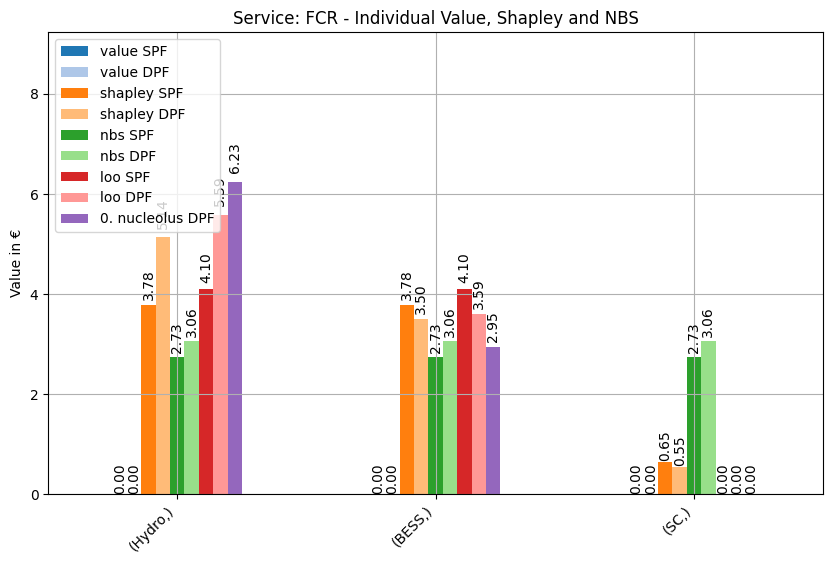

Core is non-empty, one feasible allocation: [9.1813 0.     0.    ]


<Figure size 640x480 with 0 Axes>

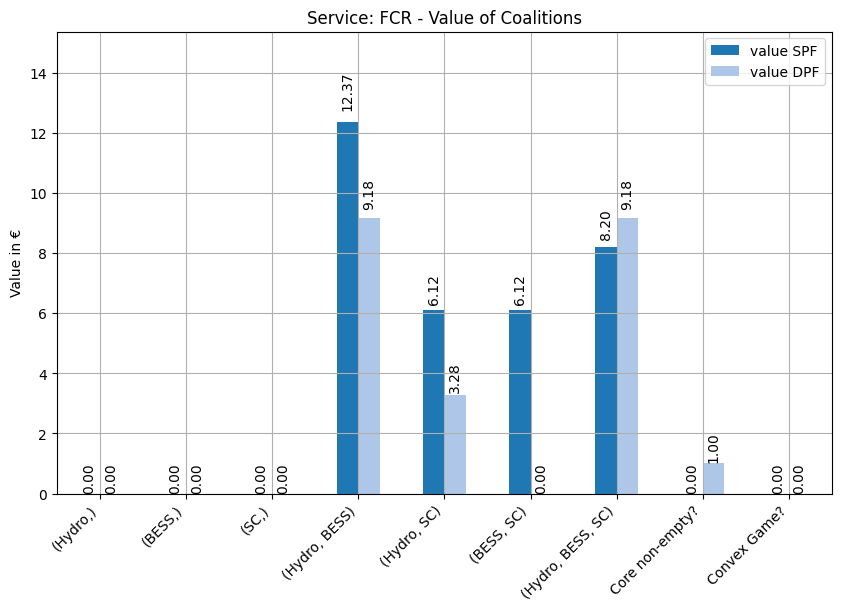

<Figure size 640x480 with 0 Axes>

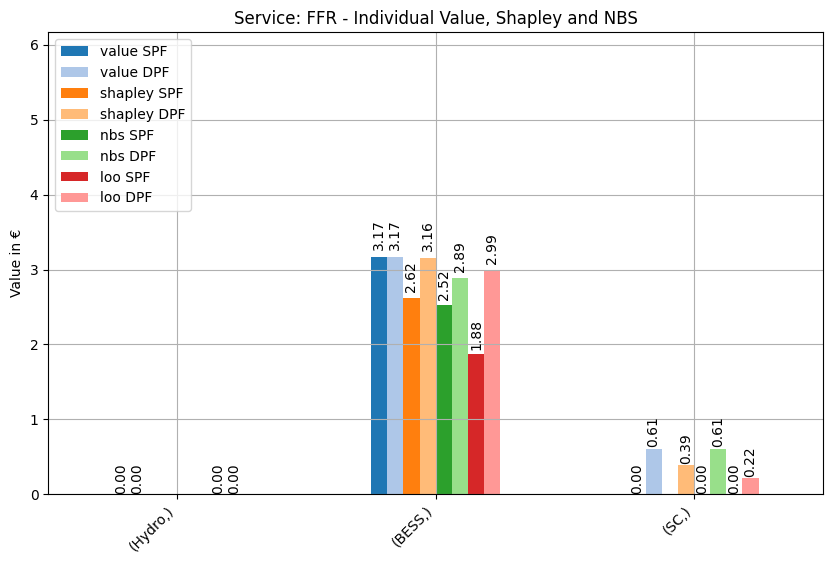

<Figure size 640x480 with 0 Axes>

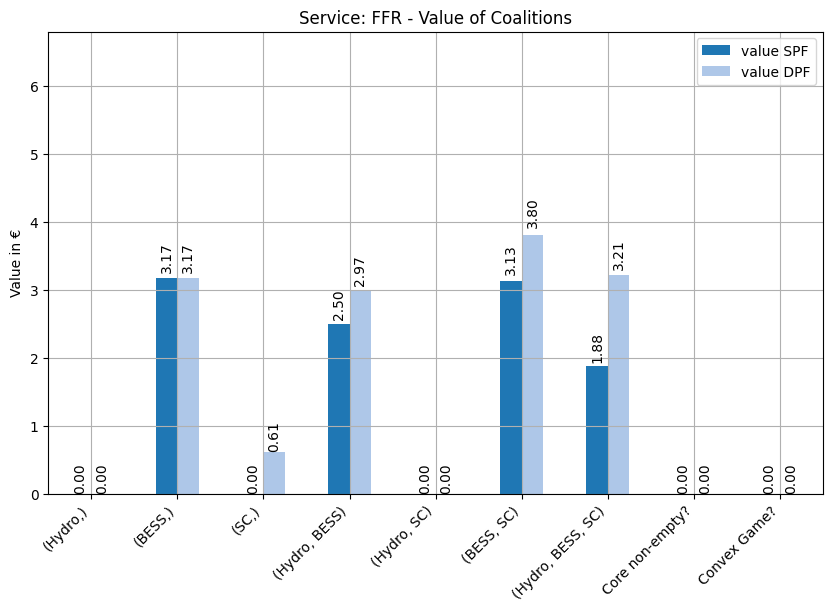

<Figure size 640x480 with 0 Axes>

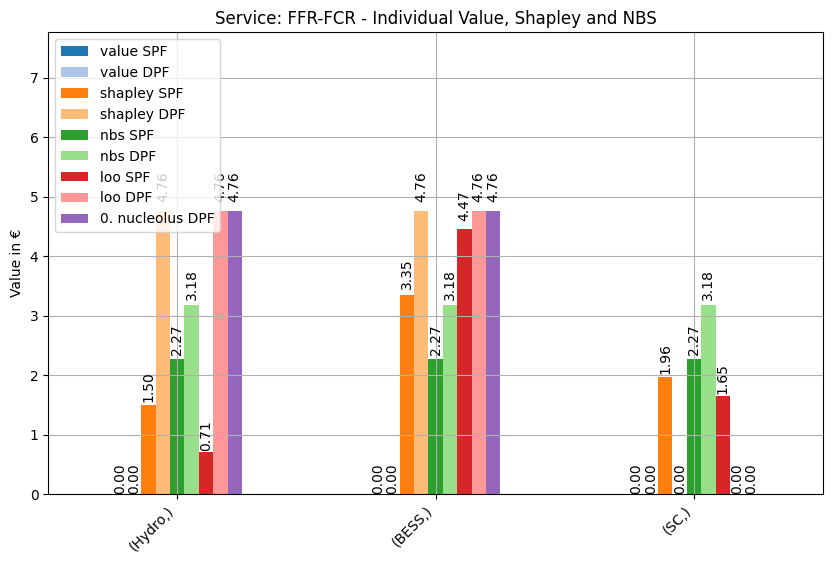

Core is non-empty, one feasible allocation: [9.52849 0.      0.     ]


<Figure size 640x480 with 0 Axes>

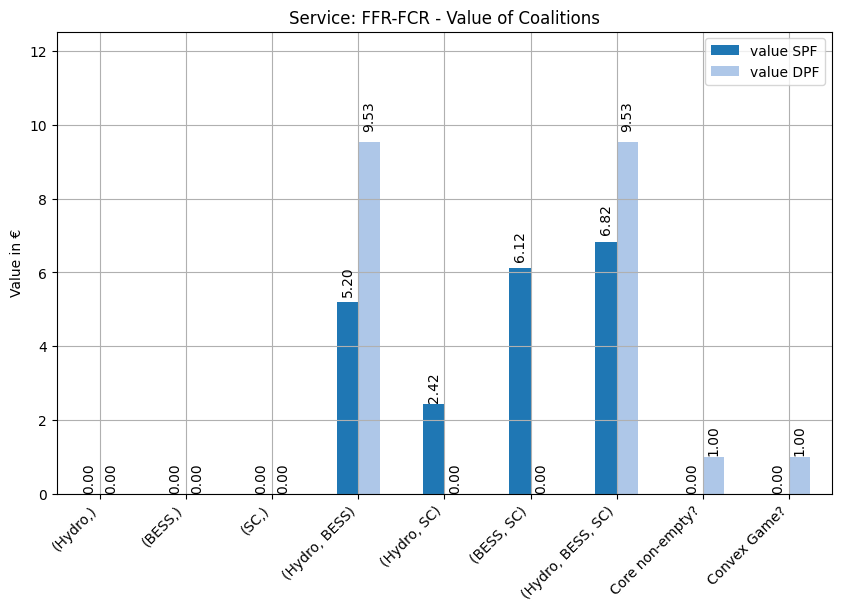

<Figure size 640x480 with 0 Axes>

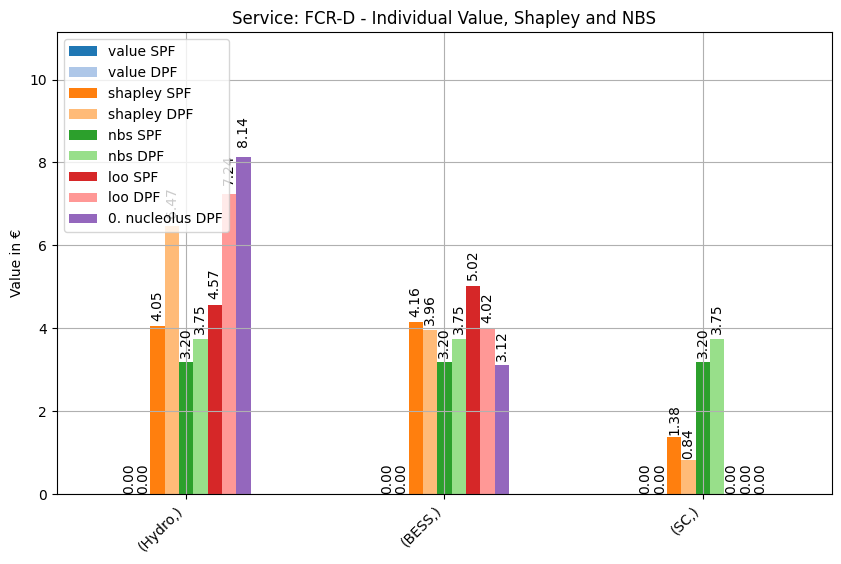

Core is non-empty, one feasible allocation: [11.26445  0.       0.     ]


<Figure size 640x480 with 0 Axes>

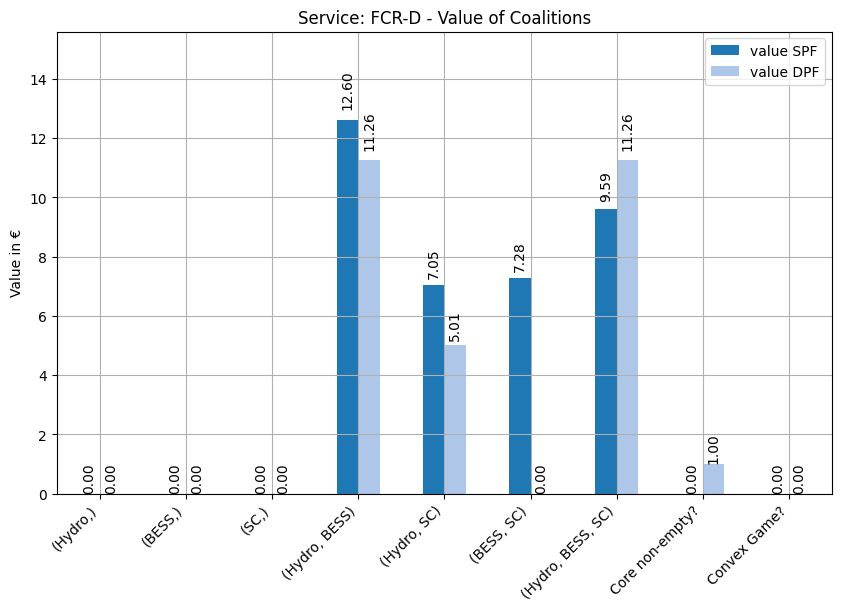

In [56]:
visualize_value_results(df_new, df_newstat)

## DVPP3: PV and Wind sinusodial

Using adpative dynamic PF (ADPF) with setttings 

{'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }
    
def adaptive_pv_func(t):
    return .3 + .7 * np.sin(t / 5)**2

def adaptive_wind_func(t):
    return .3 + .7 * np.cos(t / 5 + .5)**2

In [72]:
# load data
df = pd.read_csv('pics/v3/PV_Wind_sinus/values_ADPF.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,6.35233,6.58379,0.00000,12.70465,6.68666,6.68666,24.61205
FFR,1.18976,1.01517,3.16838,2.14674,4.24174,4.00897,5.14053
FFR-FCR,4.96356,4.03771,0.00000,8.53835,6.22374,6.22374,20.44574
FCR-D,6.58379,6.58379,0.00000,13.16757,6.22374,6.22374,13.50191


In [73]:
df_stat = pd.read_csv('pics/v3/PV_Wind_sinus/values_DPF.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,6.35233,6.58379,0.00000,13.16757,6.22374,6.68666,12.80752
FFR,1.18976,1.01517,3.16838,2.14674,4.24174,4.00897,5.14053
FFR-FCR,4.96356,4.03771,0.00000,8.53835,6.22374,6.68666,12.80752
FCR-D,6.58379,6.58379,0.00000,13.16757,6.22374,6.68666,12.80752


In [74]:
players = list(str(x[0]) for x in df.columns[:3])
df_new = add_reward_mechanisms(df, players, add_LOO=True)
df_newstat = add_reward_mechanisms(df_stat, players, add_LOO=True)

Core is non-empty, one feasible allocation: [17.92539  6.68666  0.     ]
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [14.222    6.22374  0.     ]
Core is non-empty, one feasible allocation: [6.91812 6.58379 0.     ]
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [6.12086 6.58378 0.10288]
Core is empty for FCR-D, skipping nucleolus computation.


In [75]:
df_v2A = df_new.copy()
df_v2Astat = df_newstat.copy()

<Figure size 640x480 with 0 Axes>

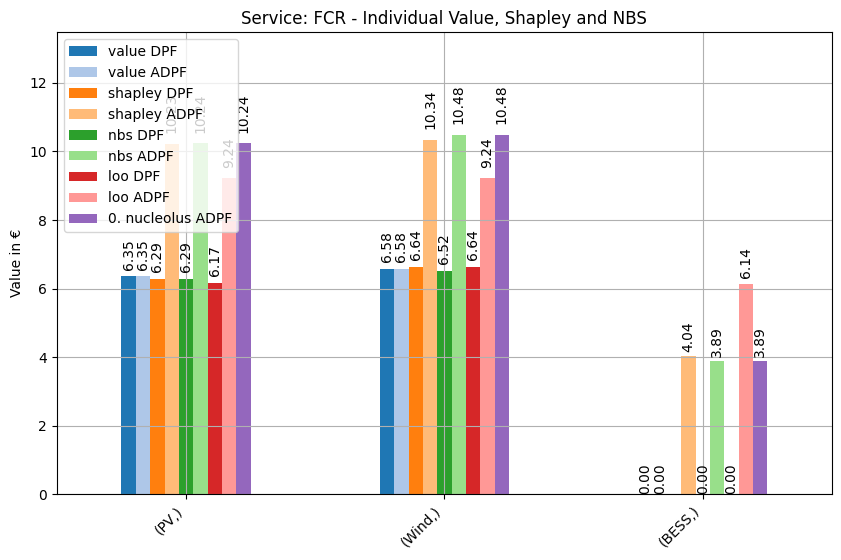

Core is non-empty, one feasible allocation: [17.92539  6.68666  0.     ]


<Figure size 640x480 with 0 Axes>

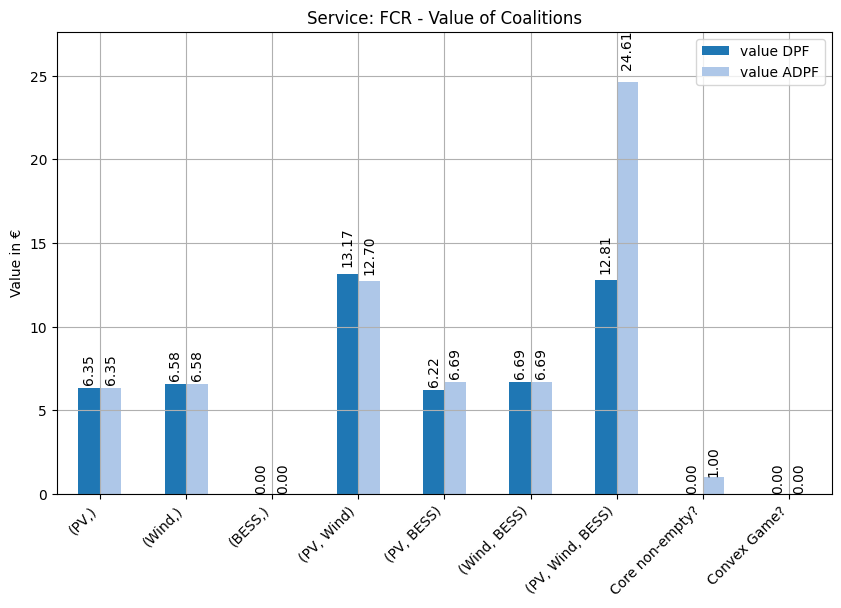

<Figure size 640x480 with 0 Axes>

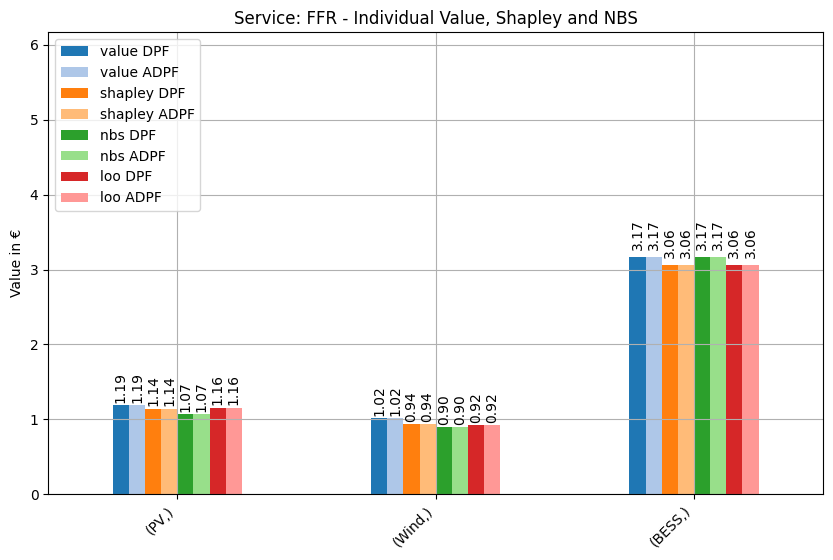

<Figure size 640x480 with 0 Axes>

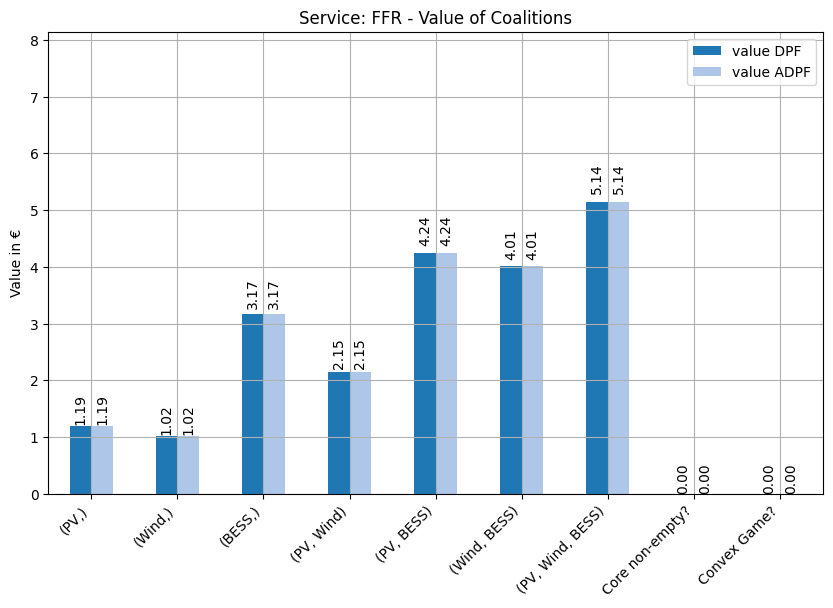

<Figure size 640x480 with 0 Axes>

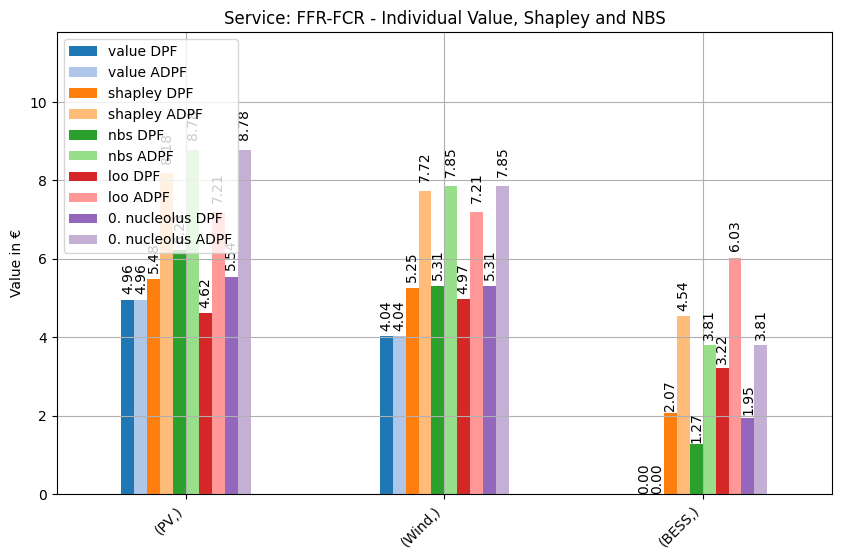

Core is non-empty, one feasible allocation: [6.12086 6.58378 0.10288]
Core is non-empty, one feasible allocation: [14.222    6.22374  0.     ]


<Figure size 640x480 with 0 Axes>

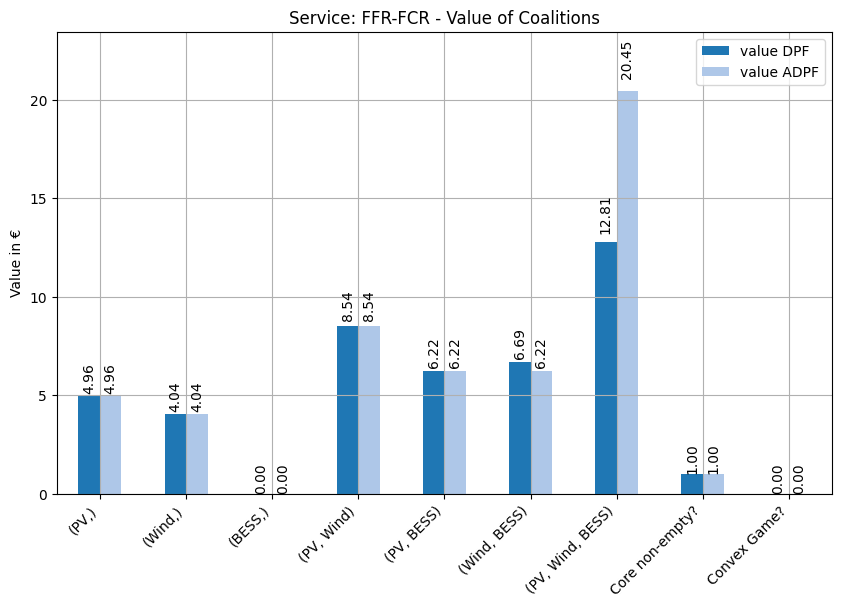

<Figure size 640x480 with 0 Axes>

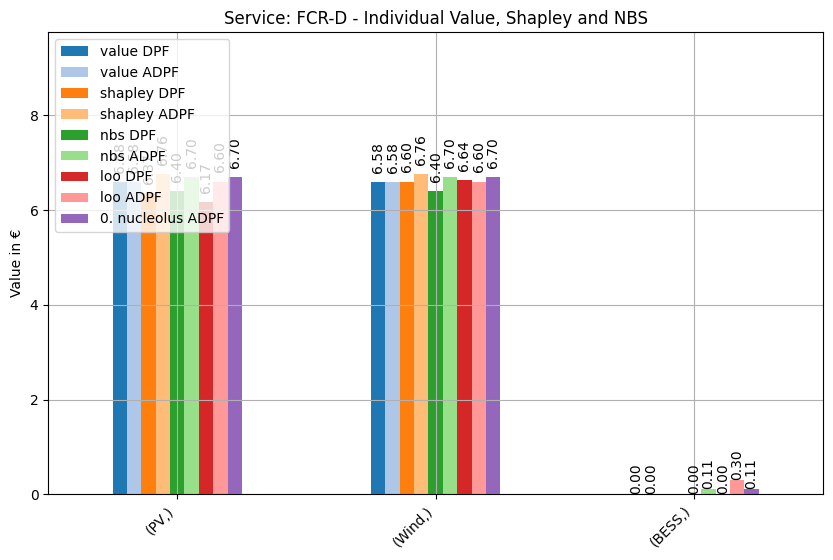

Core is non-empty, one feasible allocation: [6.91812 6.58379 0.     ]


<Figure size 640x480 with 0 Axes>

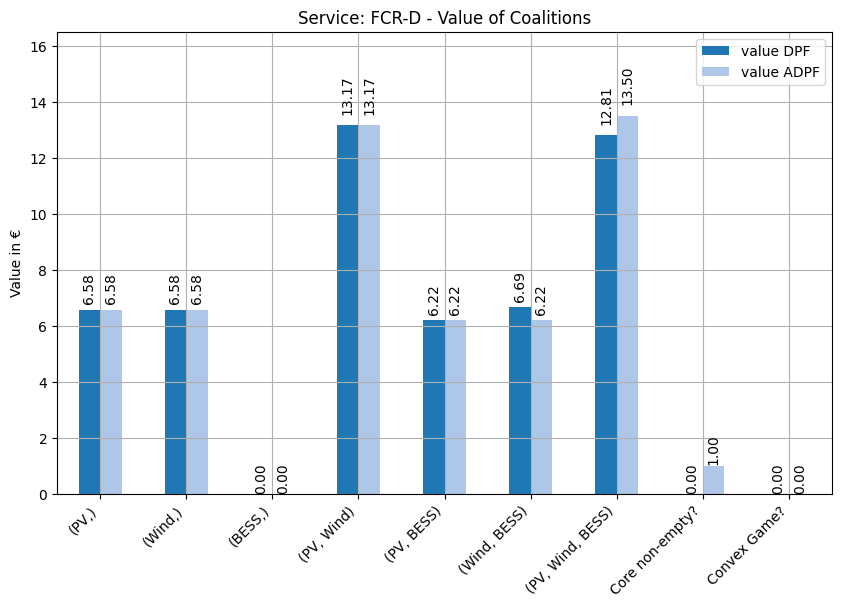

In [76]:
visualize_value_results(df_new, df_newstat, pf_names=['ADPF', 'DPF'])

## DVPP3 : PV drop

Using adpative dynamic PF (ADPF) with setttings 

def get_io_dict():
        return {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=4), 'hpf', 1),
                }
    
    def adaptive_pv_func(t):
        return np.where(t<5, 1, np.exp(-.1*(t-5)))
        # return 1 + .5 * np.sin(t / 5)
    
    def adaptive_wind_func(t):
        return 1
        # return 1 + .5 * np.sin(t / 5 + .1)

    pfs_to_run = [True , False, 'ADPF']

    set_service_rating = {
        'FCR': 1.8,   # 1 MW
        'FFR': 2.0,   # 1 MW
        'FFR-FCR': 1.8,   # 1.5 MW
        'FCR-D': 1.8,   # 1 MW
    }

In [57]:
# load data
df = pd.read_csv('pics/v3/PV_drop_to_zero/values_ADPF.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,0.00000,12.13886,0.00000,12.26745,0.00000,22.68320,22.26657
FFR,1.13156,0.89878,3.16838,2.03035,4.24174,4.00897,5.05647
FFR-FCR,0.00000,3.80625,0.00000,8.10114,0.00000,12.26745,20.18342
FCR-D,0.00000,12.60178,0.00000,12.26745,0.00000,12.26745,22.68320


In [58]:
df_stat = pd.read_csv('pics/v3/PV_drop_to_zero/values_DPF.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,0.00000,12.13886,0.00000,9.76767,9.76767,22.26657,9.76767
FFR,1.13156,0.89878,3.16838,2.03035,4.24174,4.00897,5.05647
FFR-FCR,0.00000,3.80625,0.00000,8.10114,0.00000,12.26745,9.76767
FCR-D,0.00000,12.60178,0.00000,9.76767,0.00000,12.26745,9.76767


In [59]:
players = list(str(x[0]) for x in df.columns[:3])

In [60]:
df_new = add_reward_mechanisms(df, players, add_LOO=True)
df_newstat = add_reward_mechanisms(df_stat, players, add_LOO=True)

Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [ 7.91597 12.26745  0.     ]
Core is non-empty, one feasible allocation: [10.08142 12.60178  0.     ]
Core is empty for FCR, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is empty for FFR-FCR, skipping nucleolus computation.
Core is empty for FCR-D, skipping nucleolus computation.


In [61]:
df_v2A = df_new.copy()
df_v2Astat = df_newstat.copy()

<Figure size 640x480 with 0 Axes>

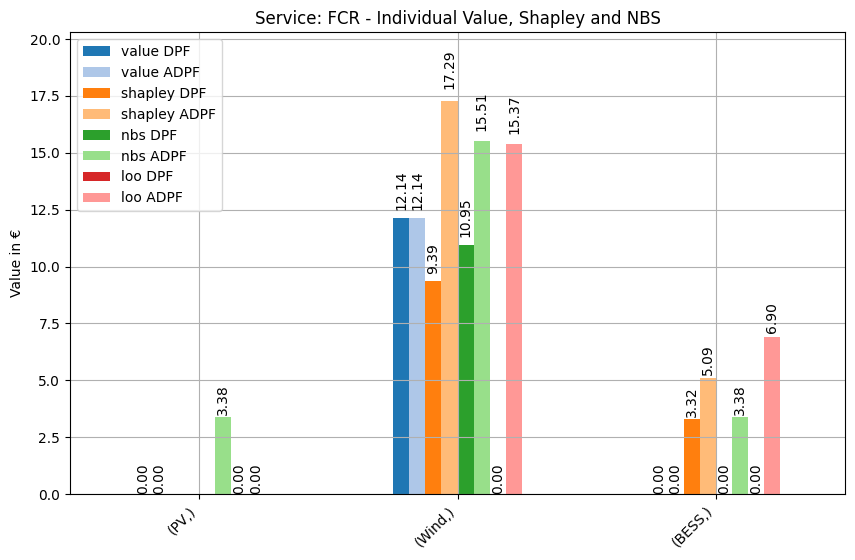

<Figure size 640x480 with 0 Axes>

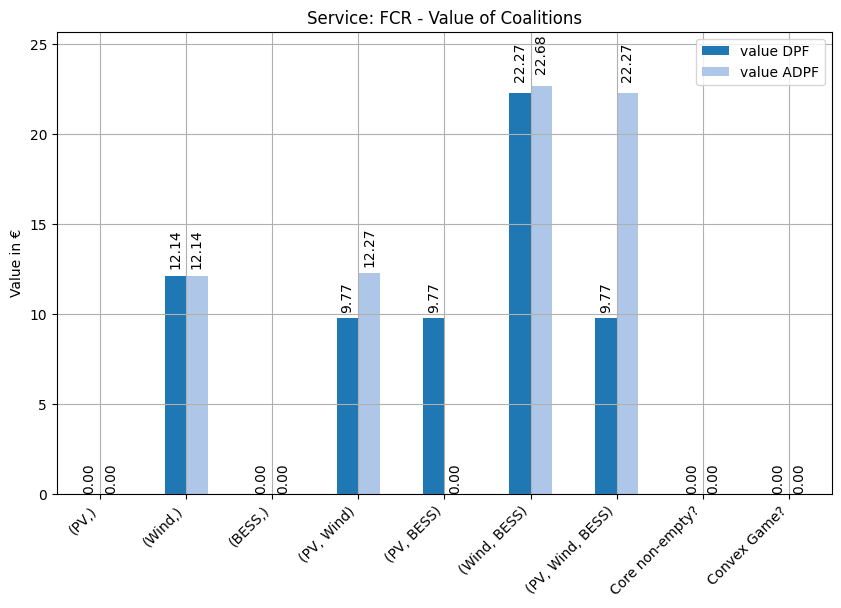

<Figure size 640x480 with 0 Axes>

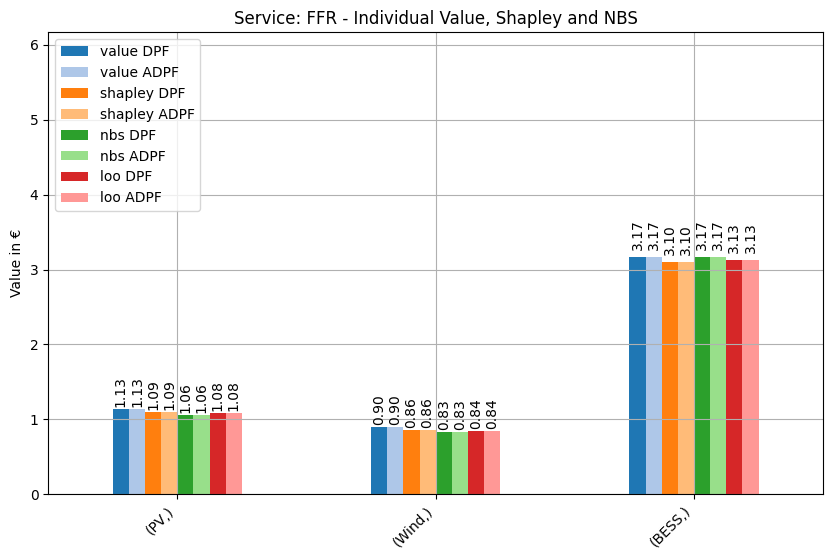

<Figure size 640x480 with 0 Axes>

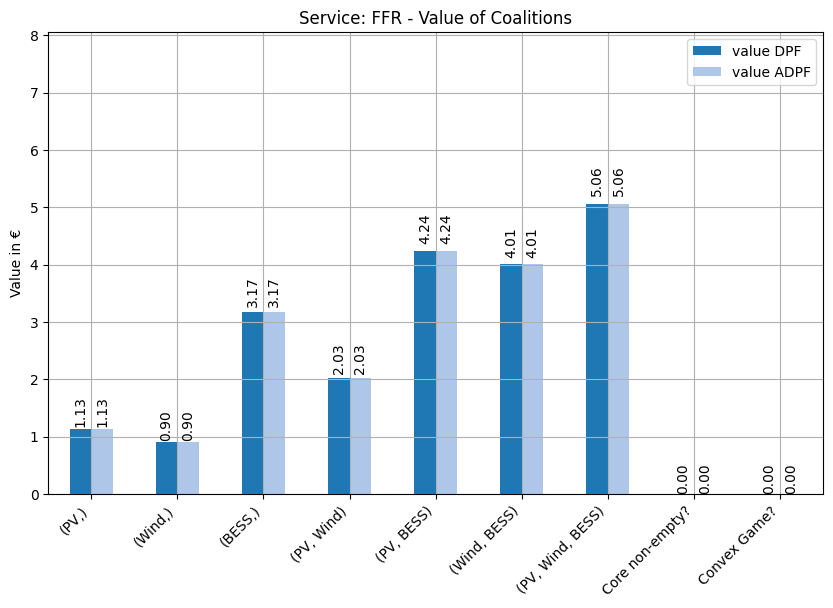

<Figure size 640x480 with 0 Axes>

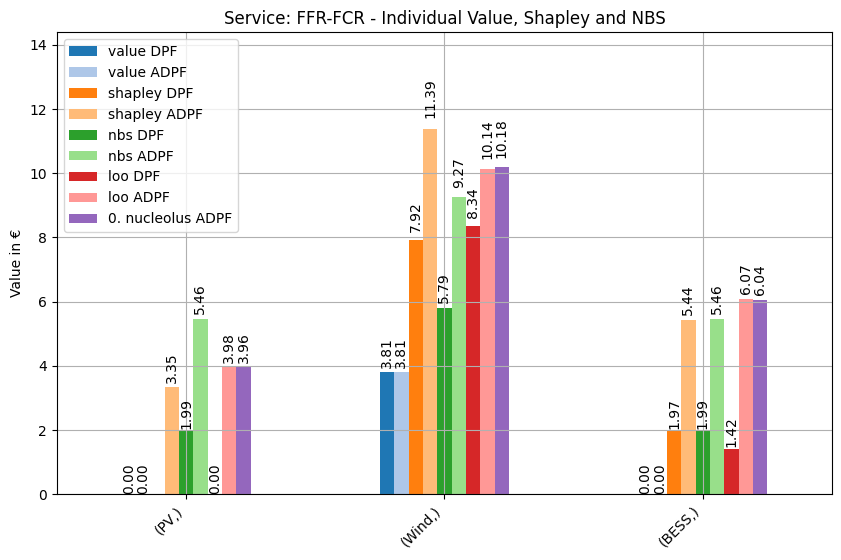

Core is non-empty, one feasible allocation: [ 7.91597 12.26745  0.     ]


<Figure size 640x480 with 0 Axes>

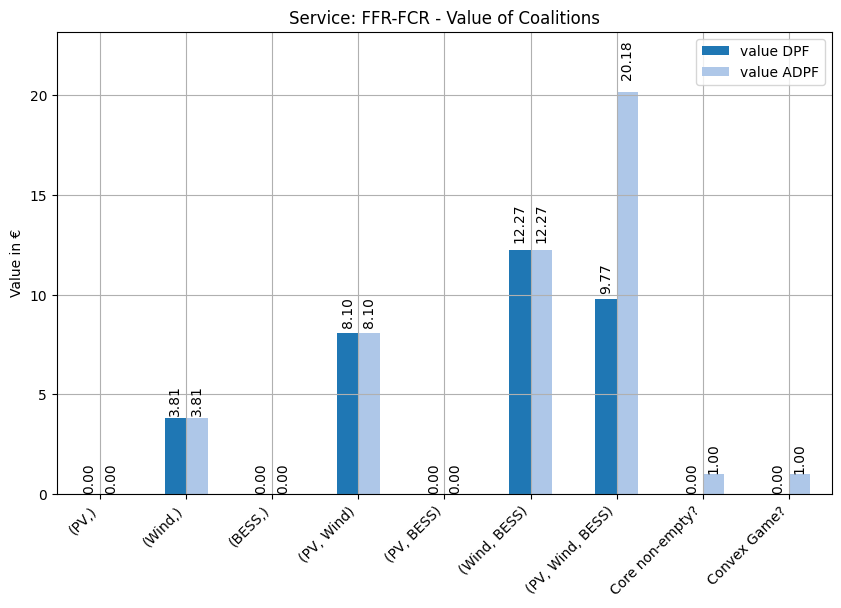

<Figure size 640x480 with 0 Axes>

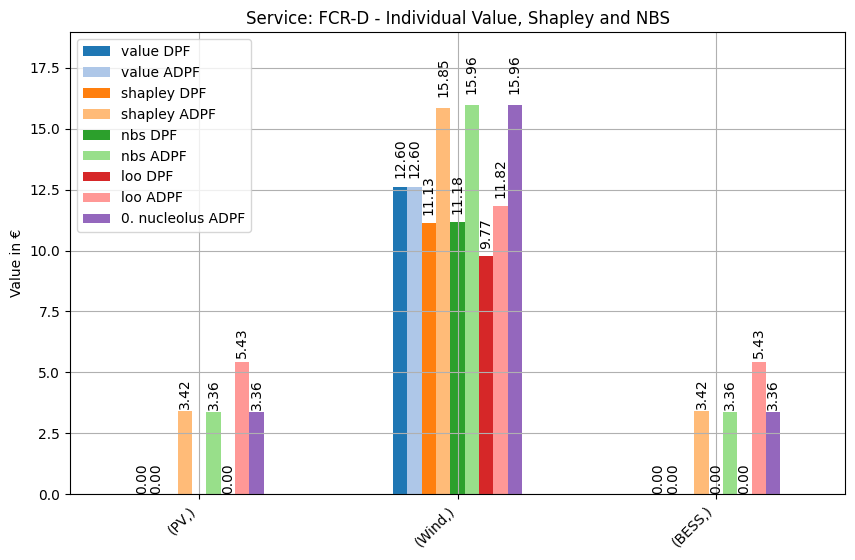

Core is non-empty, one feasible allocation: [10.08142 12.60178  0.     ]


<Figure size 640x480 with 0 Axes>

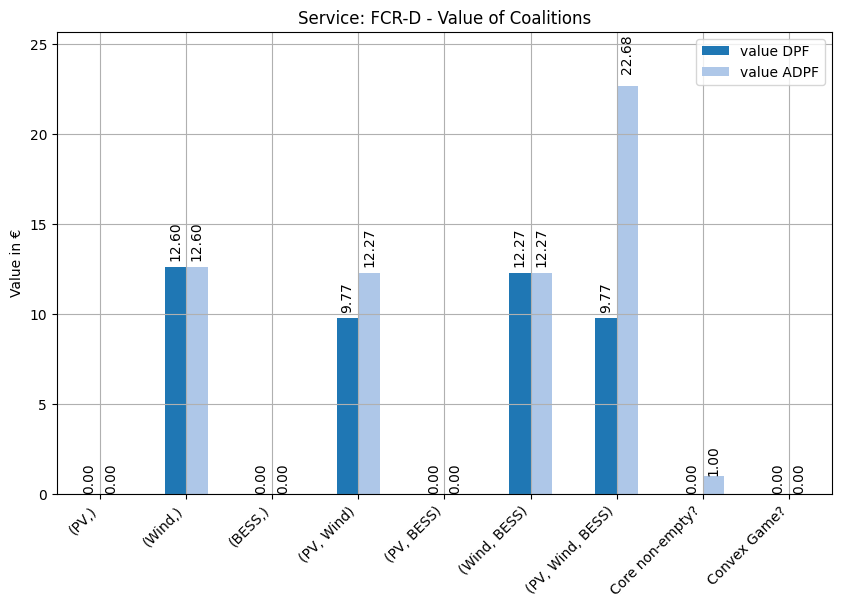

In [62]:
visualize_value_results(df_new, df_newstat, pf_names=['ADPF', 'DPF'])

## compare scenarios

### NBS

<Figure size 640x480 with 0 Axes>

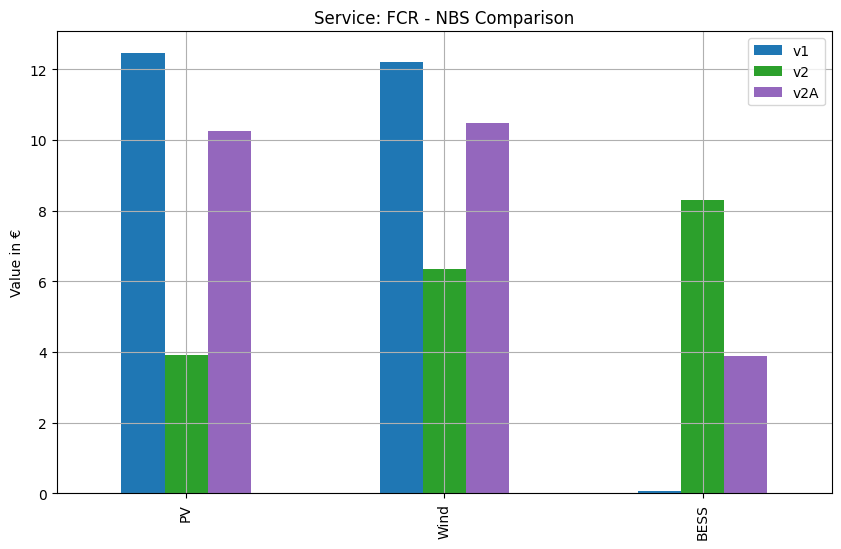

<Figure size 640x480 with 0 Axes>

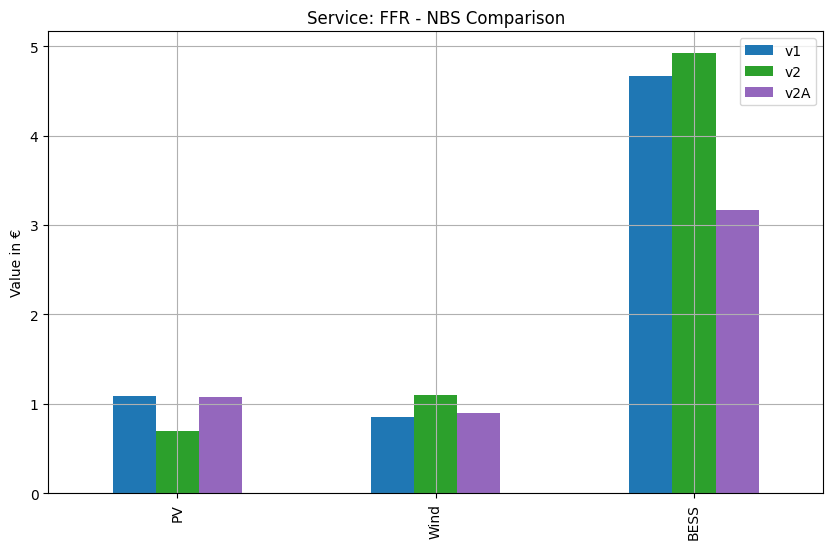

<Figure size 640x480 with 0 Axes>

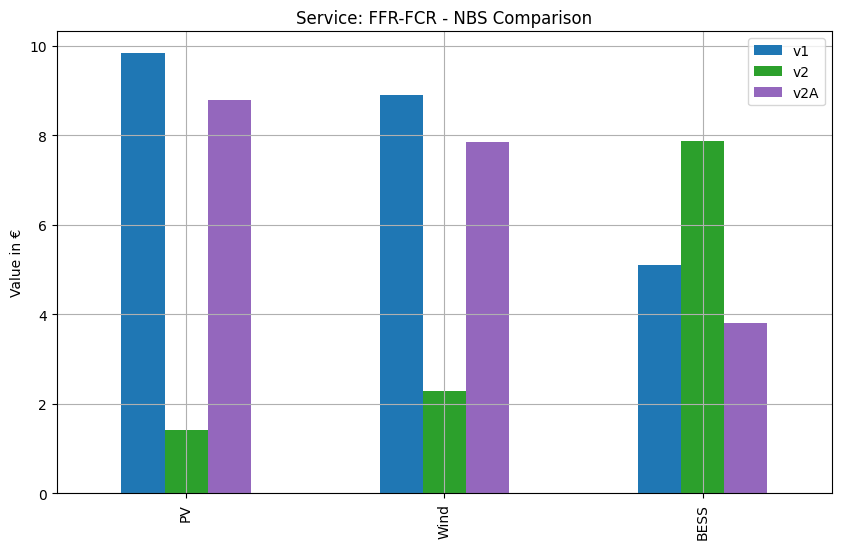

<Figure size 640x480 with 0 Axes>

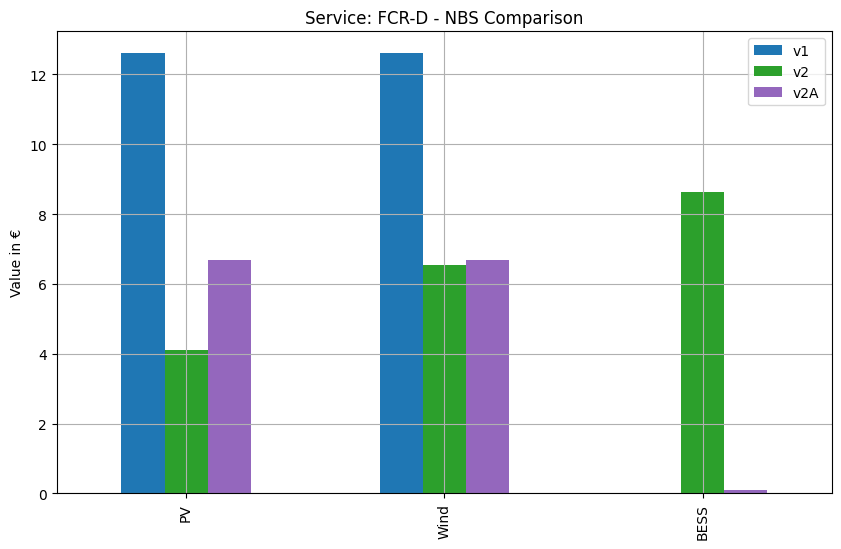

In [69]:
# NBS
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# get new colors
colors = plt.cm.tab20(np.linspace(0, .4, len(cases)))
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['nbs'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - NBS Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### Nucleolus

C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_22848\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local

Could not plot nucleolus for FCR in case v2: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v1: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2A: Length of values (0) does not match length of index (3)


<Figure size 640x480 with 0 Axes>

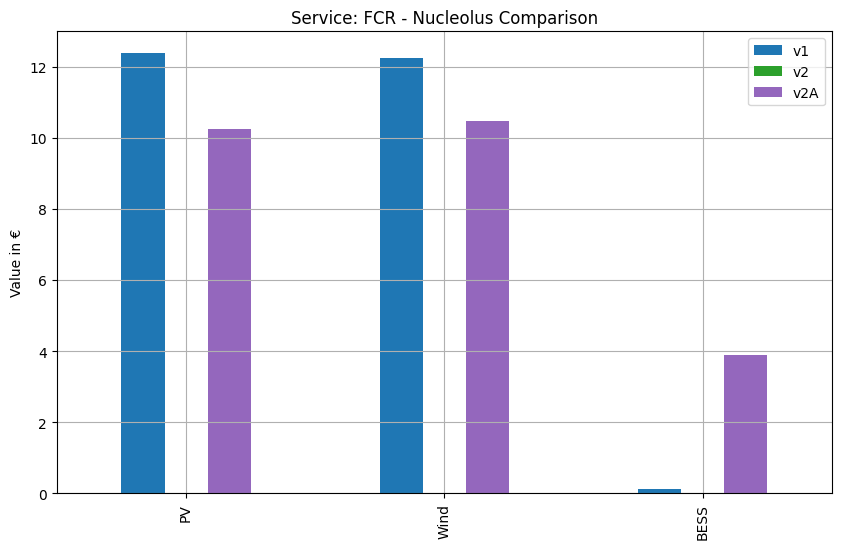

<Figure size 640x480 with 0 Axes>

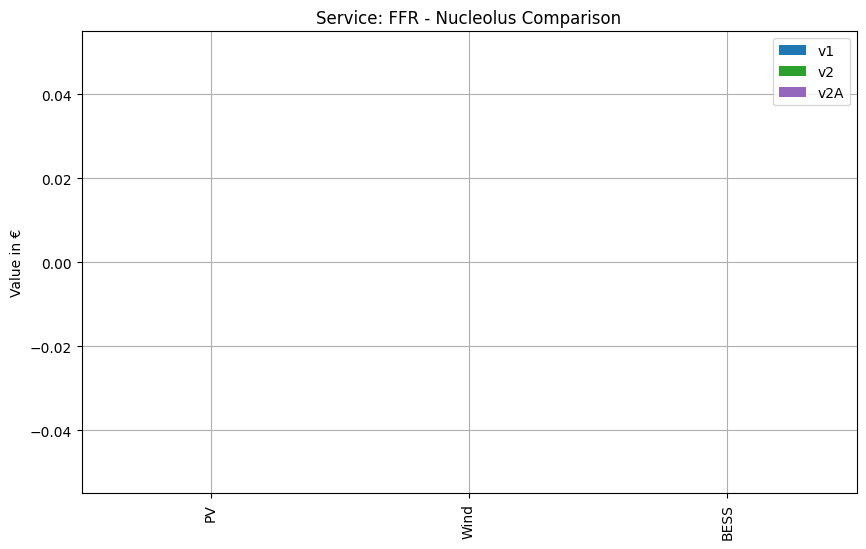

<Figure size 640x480 with 0 Axes>

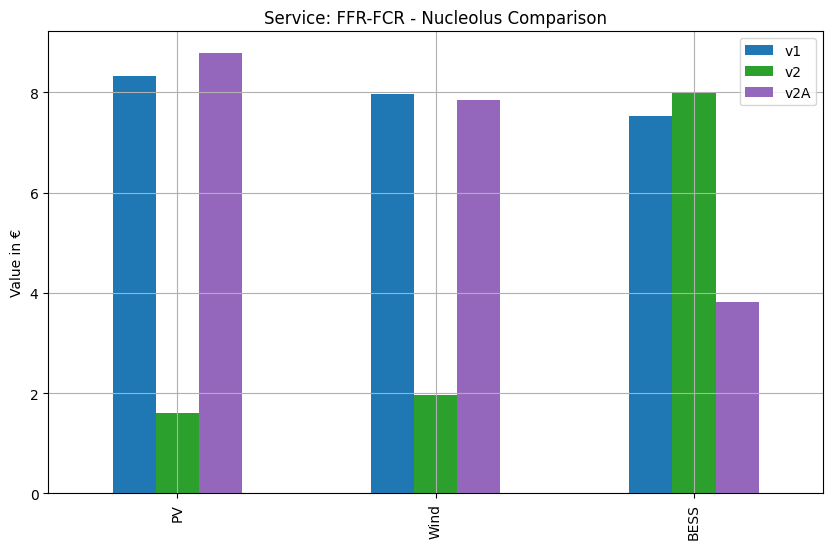

<Figure size 640x480 with 0 Axes>

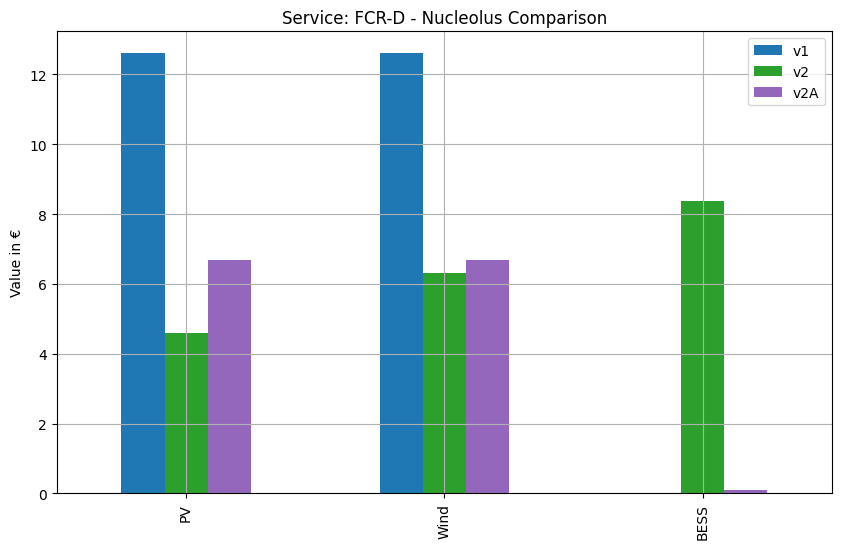

In [70]:
# compare Nucleolus
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        try:
            df_plot = df.loc[service].loc['0. nucleolus'].dropna().astype(float)
            df_final.loc[:, cases[i]] = df_plot.values
        except Exception as e:
            print(f"Could not plot nucleolus for {service} in case {cases[i]}: {e}")
            continue
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - Nucleolus Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### LOO

<Figure size 640x480 with 0 Axes>

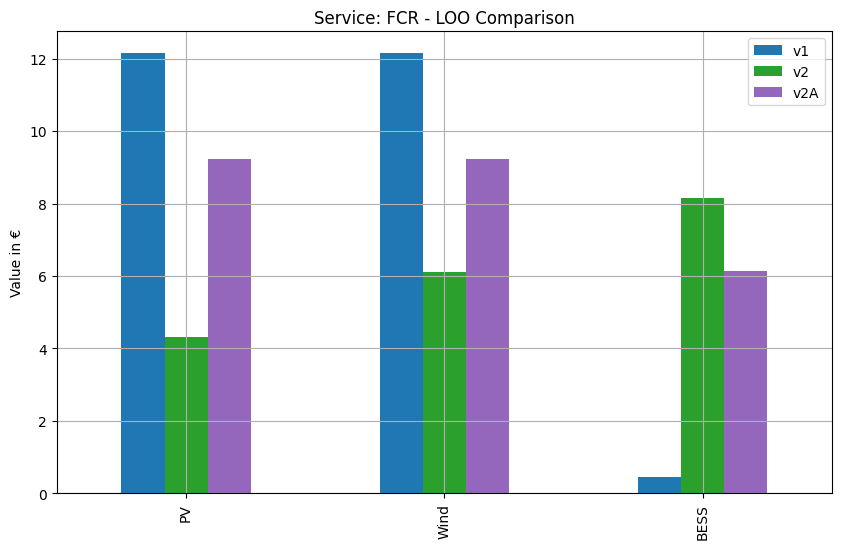

<Figure size 640x480 with 0 Axes>

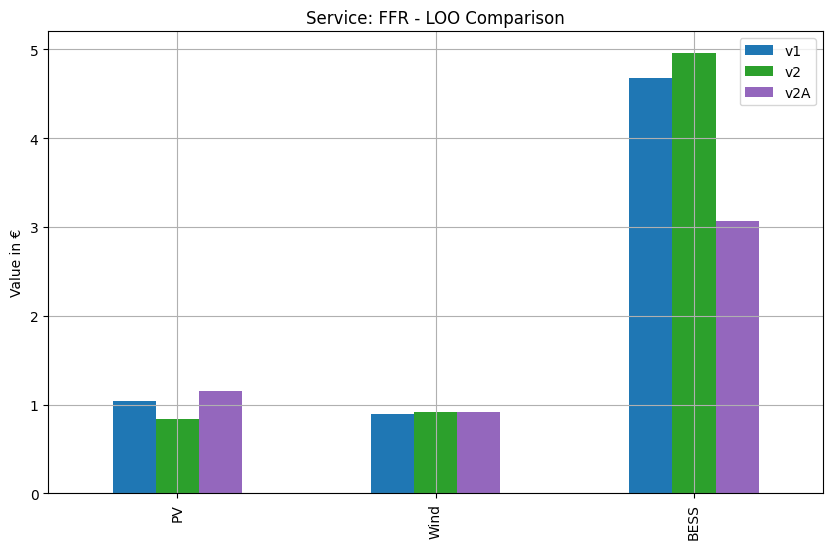

<Figure size 640x480 with 0 Axes>

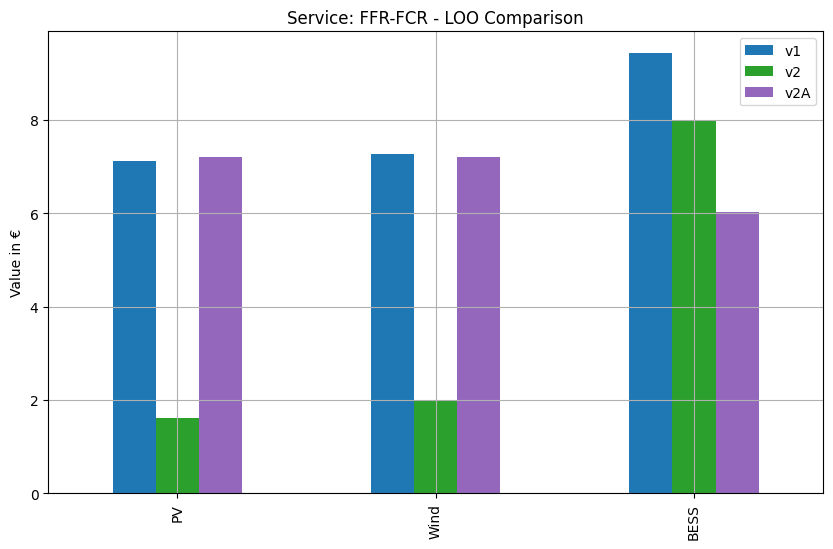

<Figure size 640x480 with 0 Axes>

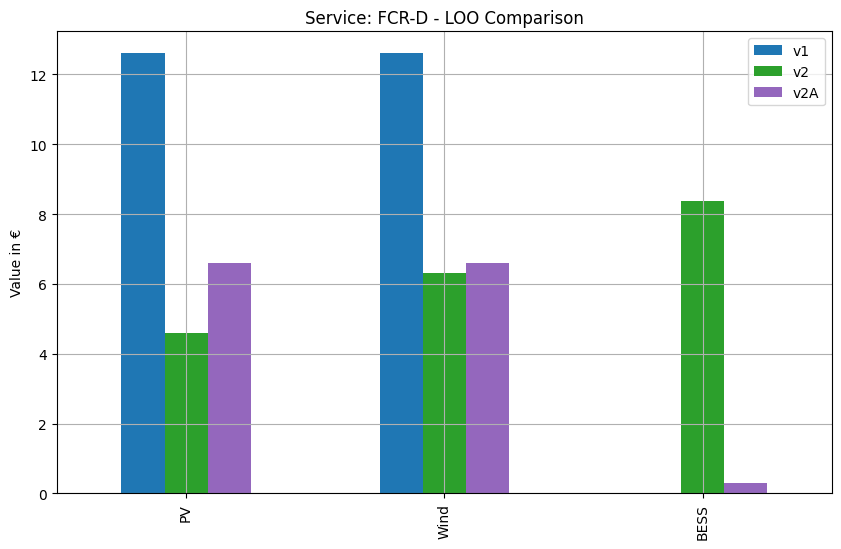

In [71]:
# compare LOO
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['loo'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - LOO Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

# Uncertainty Calculation and Visual

calculate 1st and 2ed stage reward split

In [12]:
# get forecasted vals
dff = pd.read_csv('pics/vu2/values_forecasted_DPF.csv', index_col=0, header=[0,1,2])
dff.columns = [tuple(c for c in col if c!='nan') for col in dff.columns.values]
dff.index = pd.MultiIndex.from_arrays([dff.index, dff.iloc[:, 0]], names=['Service', 'Scenario'])
dff.drop(dff.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in dff.columns[:3])
dff.head()

(PV,)  (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                      
FCR     0         3.92581  2.50225    -2.94     6.35460     3.92581   
        1        -0.10852  0.59711    -0.60     0.63196     0.00000   
        2         6.88012  3.51495    -3.60    10.26634     6.88012   
        3         3.77917  1.63885    -2.40     5.34732     3.77917   
        4         1.80706  1.20895    -1.50     2.98220     1.80706   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              2.54996           6.47577  
        1              0.60850           0.64401  
        2              3.58197          10.46209  
        3              1.70135           5.44928  
        4              1.25505           3.03906

In [13]:
# get realization vals
df = pd.read_csv('pics/vu2/values_DPF.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

(PV,)  (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                      
FCR     0         3.44417  5.84719    -2.94     6.23789     3.49317   
        1        -0.00355  0.59009    -0.60     0.59714     0.00000   
        2         5.16525  7.12554    -3.60    10.07777     5.23732   
        3         4.32526  3.38586    -2.40     5.24910     3.70976   
        4         2.19183 -1.28237    -1.50     2.65355     1.77387   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              2.54996           6.35683  
        1              0.60850           0.60852  
        2              3.58197          10.26993  
        3              1.70135           5.34919  
        4             -1.27554           2.64832

### forecast vs. realization reward split

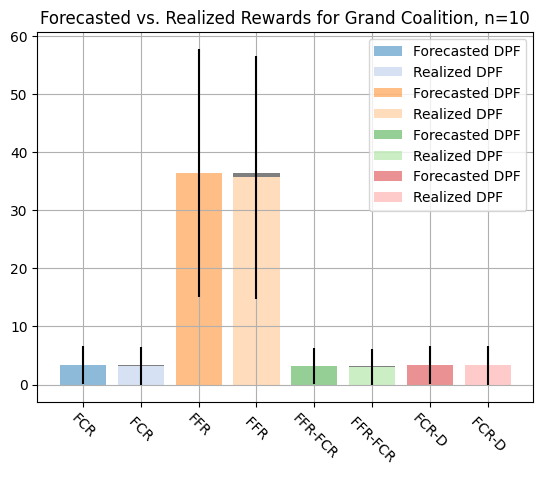

In [14]:
# plot rewards in bar plot
services = dff.index.get_level_values(0).unique()
grand_coalition = tuple(players)
rewards_forecast = dff[grand_coalition]
rewards_real = df[grand_coalition]
# make bar with std for each service
for service in services:
    data_fc = rewards_forecast.xs(service, level='Service')
    plt.bar(service, data_fc.mean(), yerr=data_fc.std(), alpha=0.5, label='Forecasted DPF')
    data_real = rewards_real.xs(service, level='Service')
    # give different x-axis position
    x_labs = ' ' + service + ' '
    plt.bar(x_labs, data_real.mean(), yerr=data_real.std(), alpha=0.5, label='Realized DPF')
    # mark difference red
    plt.bar(x_labs, data_real.mean()-data_fc.mean(), bottom=data_fc.mean(), color='black', alpha=0.5)
plt.grid()
# rotate
plt.xticks(rotation=-45)

# make big title
plt.title(f'Forecasted vs. Realized Rewards for Grand Coalition, n={len(data_fc)}')

plt.legend()
plt.show()


### Realization reward split

In [15]:
# mean over scenarios
df = df.groupby('Service').mean()
df_real = df.copy()
# set negative values to zero
df[df < 0] = 0
df_new = add_reward_mechanisms(df, players, add_LOO=True)

Core is empty for FCR, skipping nucleolus computation.
Core is empty for FCR-D, skipping nucleolus computation.
Core is empty for FFR, skipping nucleolus computation.
Core is non-empty, one feasible allocation: [1.707762 1.365397 0.      ]


<Figure size 640x480 with 0 Axes>

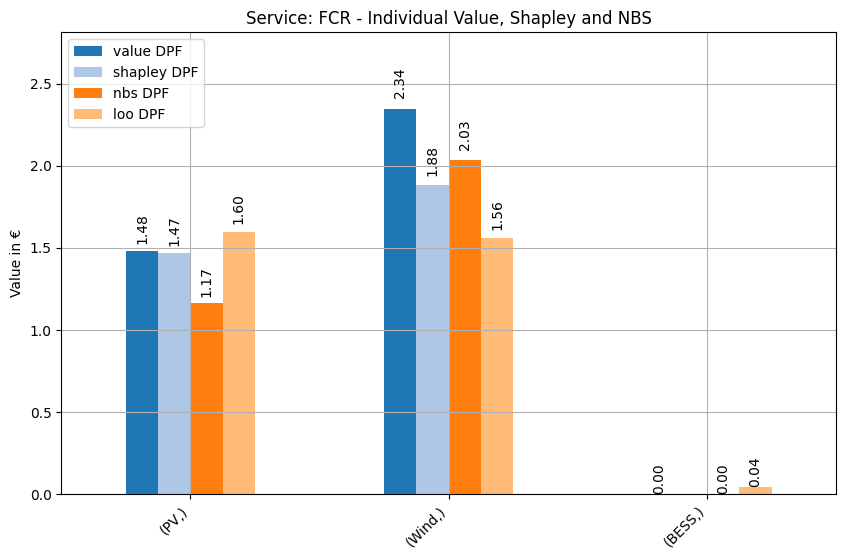

<Figure size 640x480 with 0 Axes>

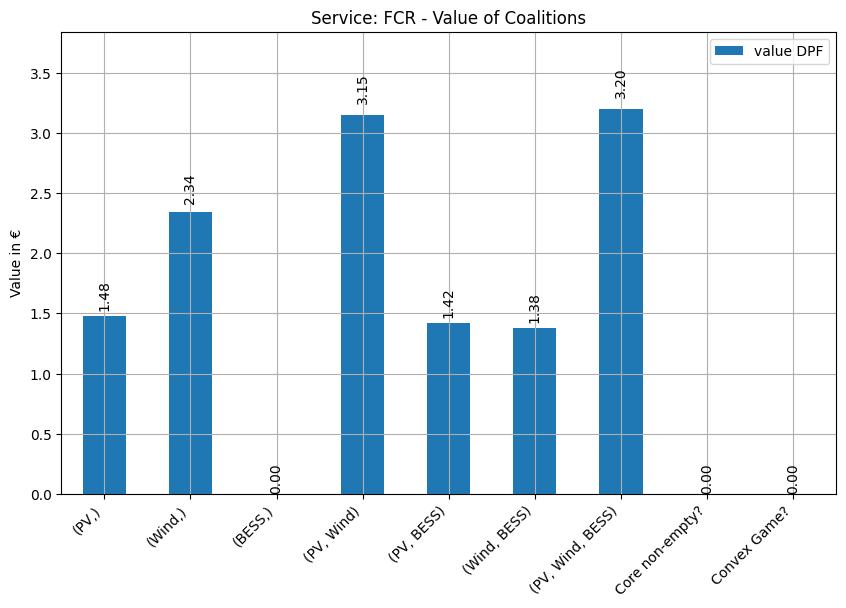

<Figure size 640x480 with 0 Axes>

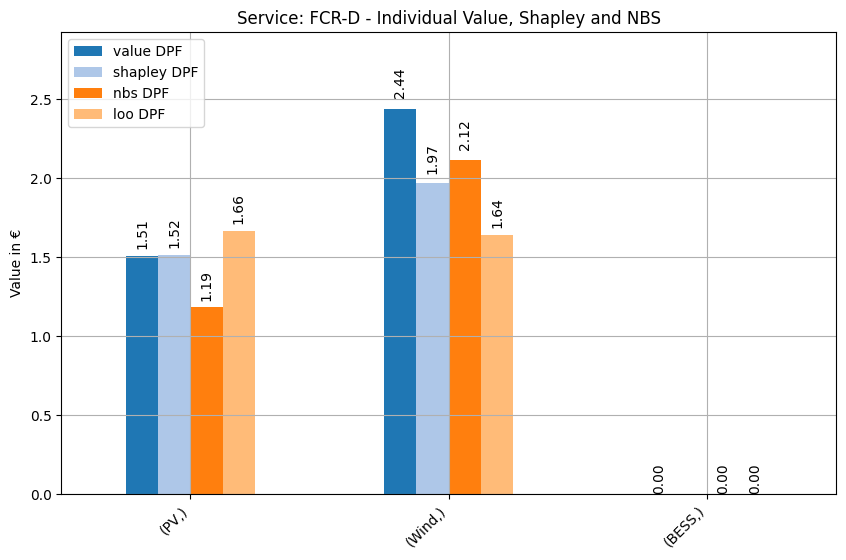

<Figure size 640x480 with 0 Axes>

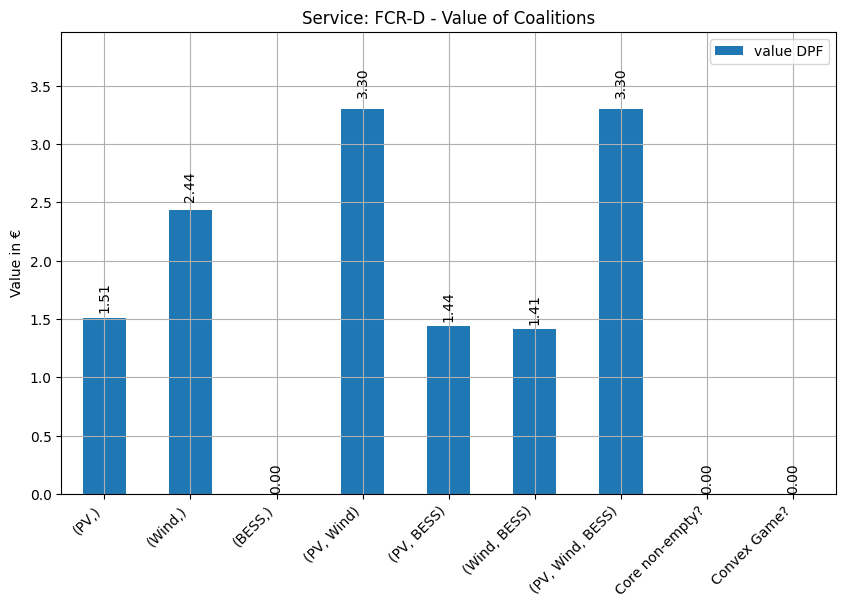

<Figure size 640x480 with 0 Axes>

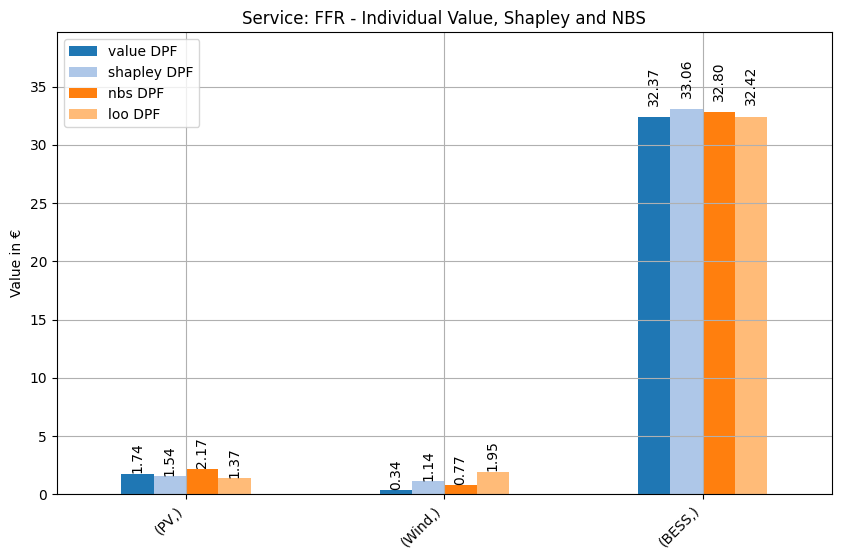

<Figure size 640x480 with 0 Axes>

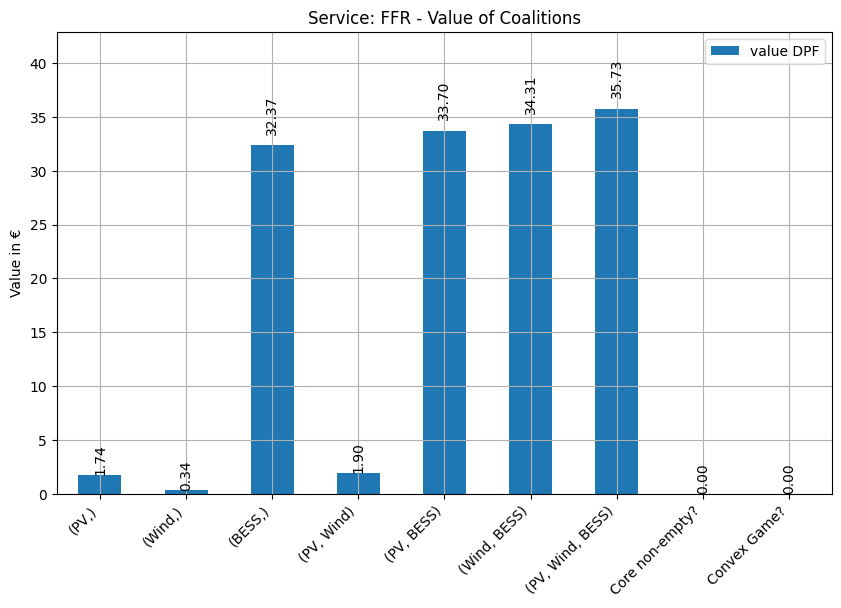

<Figure size 640x480 with 0 Axes>

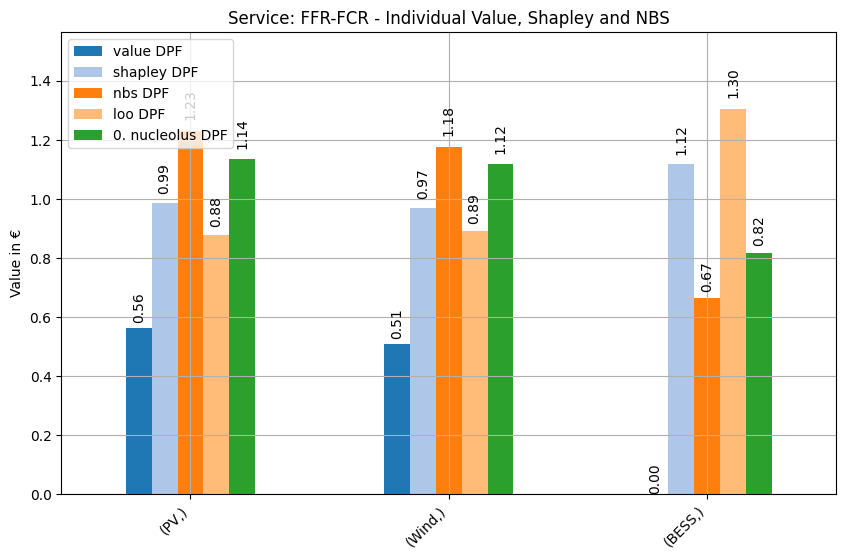

Core is non-empty, one feasible allocation: [1.707762 1.365397 0.      ]


<Figure size 640x480 with 0 Axes>

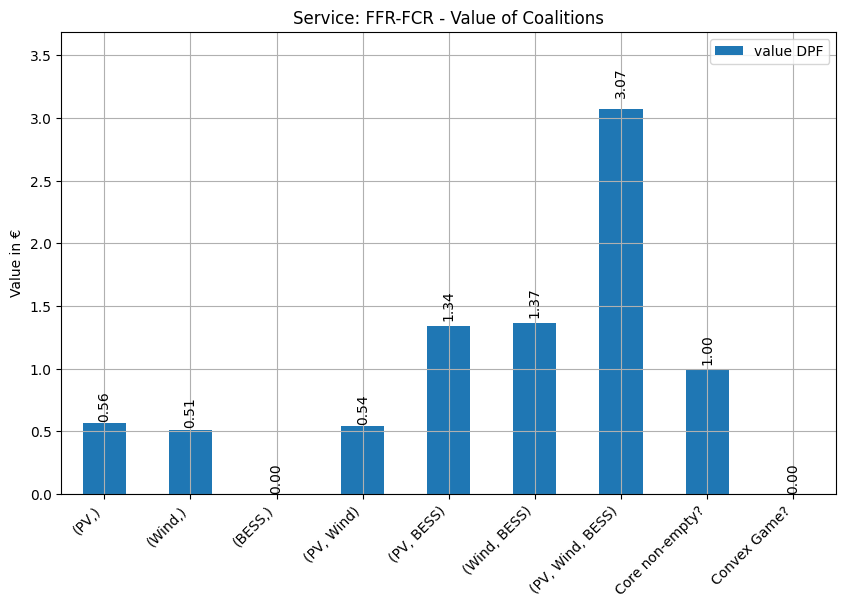

In [16]:
visualize_value_results(df_new, None)

### forecasted reward split

In [17]:
# forecasted reward split
df = pd.read_csv('pics/vu2/values_forecasted_DPF.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

# df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df

(PV,)   (Wind,)  (BESS,)  (PV, Wind)  (PV, BESS)  \
Service Scenario                                                       
FCR     0         3.92581   2.50225   -2.940     6.35460     3.92581   
        1        -0.10852   0.59711   -0.600     0.63196     0.00000   
        2         6.88012   3.51495   -3.600    10.26634     6.88012   
        3         3.77917   1.63885   -2.400     5.34732     3.77917   
        4         1.80706   1.20895   -1.500     2.98220     1.80706   
        5        -0.00000   3.17134   -2.400     3.17134     0.00000   
        6        -0.00038   1.63440   -1.500     1.63452     0.00000   
        7        -0.45663   0.54185   -0.498     0.69121    -0.46518   
        8        -0.00000   1.30730   -1.197     1.30730     0.00000   
        9        -0.00102   0.58725   -0.552     0.58758     0.00000   
FFR     0         1.45746  -2.25579   10.000     2.15685    11.23597   
        1        -1.09274 -12.88506   48.850   -13.63700    48.82010   
        2         7.92043  -9.82590   37.970    10.80519    44.68077   
        3         8.39413  -8.83934   48.840    10.85874    56.39845   
        4         1.30702  -2.12334    9.940     1.97202    11.10176   
        5        -0.00000   5.70866   48.900     5.70866    48.90000   
        6        -0.00374 -14.10452   48.840   -14.10558    48.84125   
        7        -1.21012  -3.31635   11.500     1.50148    11.65038   
        8        -0.00000 -14.14036   48.850   -14.14036    48.85000   
        9        -0.00556  -2.81967   10.000    -2.82124    10.00185   
FFR-FCR 0         1.50177  -2.35381   -2.940     2.11371     3.77890   
        1        -0.04673  -0.56169   -0.600    -0.59447     0.00000   
        2         2.63190  -3.30644   -3.600     3.41486     6.49392   
        3         1.44567  -1.54163   -2.400     1.88062     3.56704   
        4         0.69127  -1.13723   -1.500     0.99196     1.73944   
        5        -0.00000   0.99440   -2.400     0.99440     0.00000   
        6        -0.00038   0.51248   -1.500     0.51252     0.00000   
        7        -0.17468   0.16990   -0.498     0.21674    -0.43954   
        8        -0.00000   0.40992   -1.197     0.40992     0.00000   
        9        -0.00102   0.18414   -0.552     0.18424     0.00000   
FCR-D   0         3.99927   2.59767   -2.940     6.59694     3.99927   
        1        -0.10852   0.61989   -0.600     0.65606     0.00000   
        2         7.00886   3.64899   -3.600    10.65785     7.00886   
        3         3.84989   1.70135   -2.400     5.55124     3.84989   
        4         1.84087   1.25505   -1.500     3.09592     1.84087   
        5        -0.00000   3.29228   -2.400     3.29228     0.00000   
        6        -0.00038   1.69673   -1.500     1.69686     0.00000   
        7        -0.46518   0.56251   -0.498     0.71757    -0.46518   
        8        -0.00000   1.35715   -1.197     1.35715     0.00000   
        9        -0.00102   0.60964   -0.552     0.60998     0.00000   

                  (Wind, BESS)  (PV, Wind, BESS)  
Service Scenario                                  
FCR     0              2.54996           6.47577  
        1              0.60850           0.64401  
        2              3.58197          10.46209  
        3              1.70135           5.44928  
        4              1.25505           3.03906  
        5              3.23181           3.23181  
        6              1.66557           1.66569  
        7              0.55218           0.70439  
        8              1.33223           1.33223  
        9              0.59845           0.59878  
FFR     0             10.55945          12.12185  
        1             52.23733          52.95861  
        2             40.42124          47.99056  
        3             51.61189          58.41774  
        4             10.37946          11.66044  
        5             53.81059          53.81059  
        6             52.19743          52.19843  
        7             12.2

In [18]:
# mean over scenarios
df = df.groupby('Service').mean()
df_forecast = df.copy()
# set negative values to zero
df[df < 0] = 0
df_rewards_forecast = add_reward_mechanisms(df, players, add_LOO=True)

Core is non-empty, one feasible allocation: [1.652604 1.707707 0.      ]
Core is non-empty, one feasible allocation: [1.689059 1.734126 0.      ]
Core is non-empty, one feasible allocation: [ 1.849698  2.292049 32.369   ]
Core is non-empty, one feasible allocation: [1.595987 1.638574 0.      ]


<Figure size 640x480 with 0 Axes>

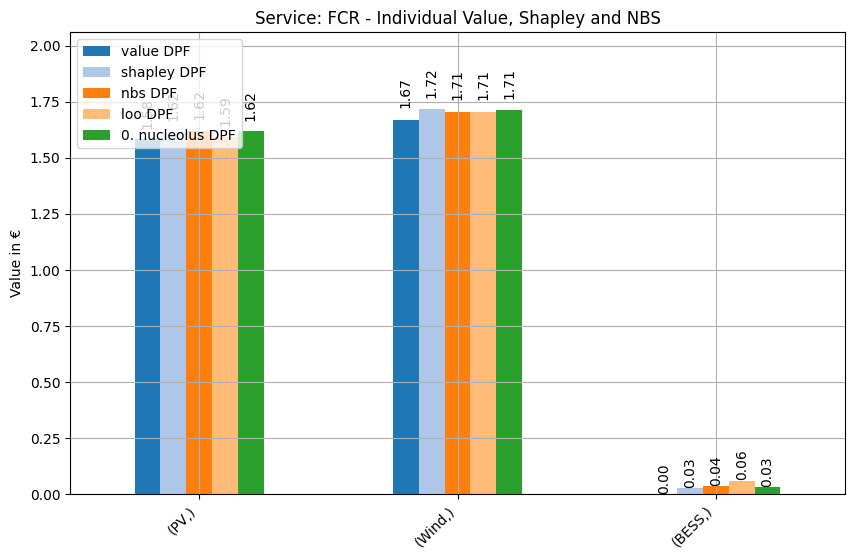

Core is non-empty, one feasible allocation: [1.652604 1.707707 0.      ]


<Figure size 640x480 with 0 Axes>

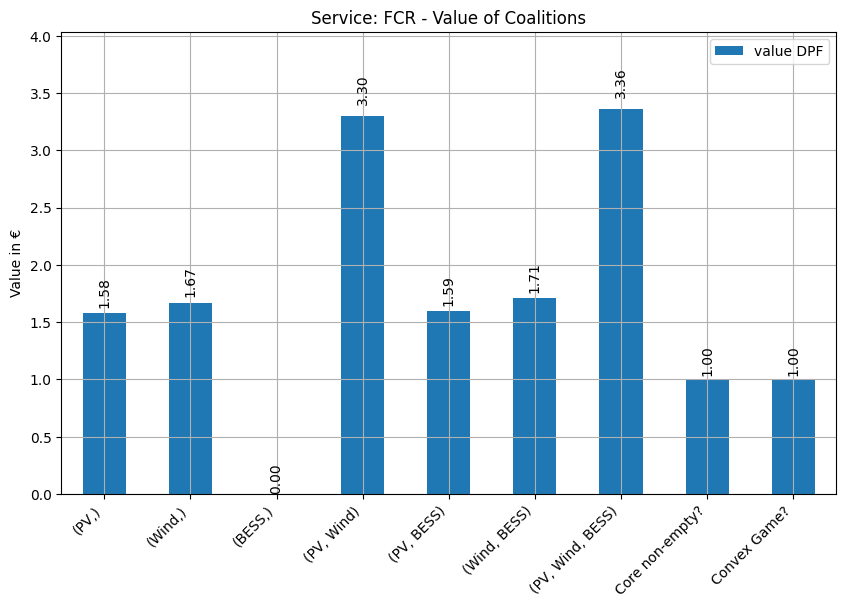

<Figure size 640x480 with 0 Axes>

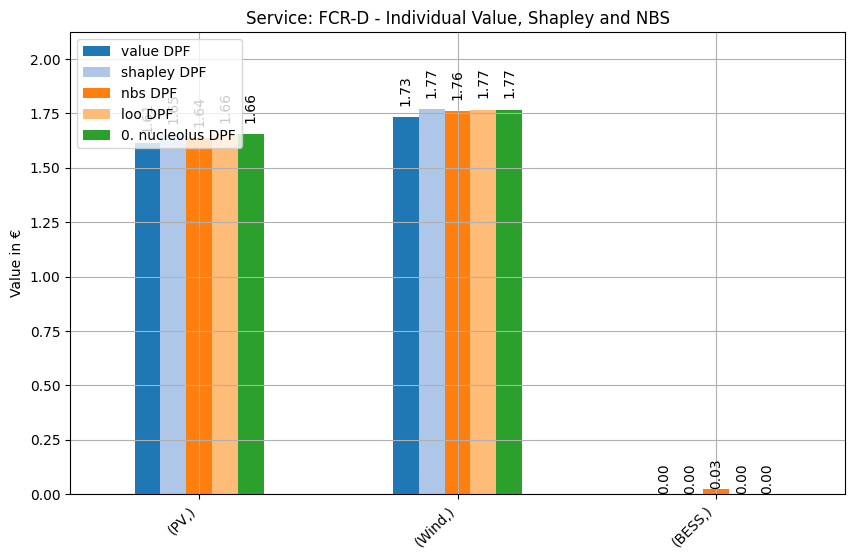

Core is non-empty, one feasible allocation: [1.689059 1.734126 0.      ]


<Figure size 640x480 with 0 Axes>

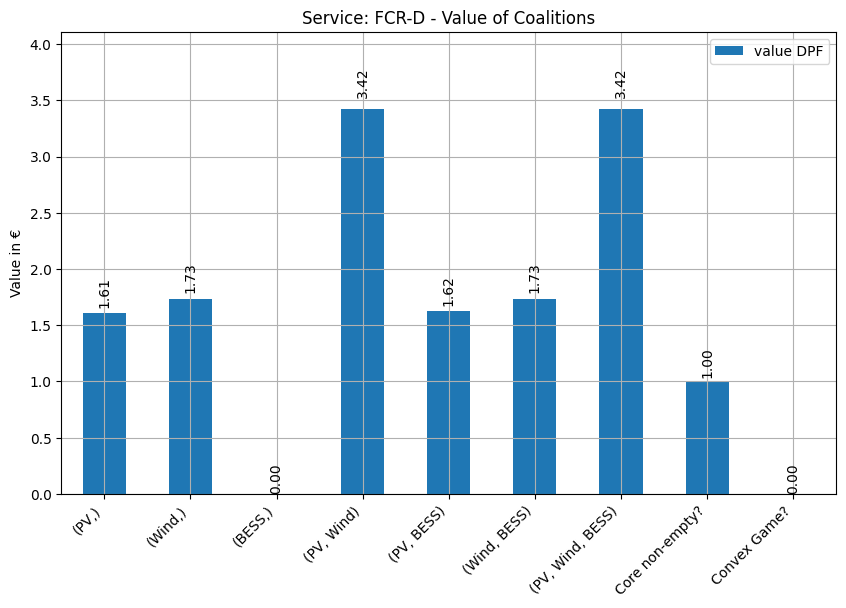

<Figure size 640x480 with 0 Axes>

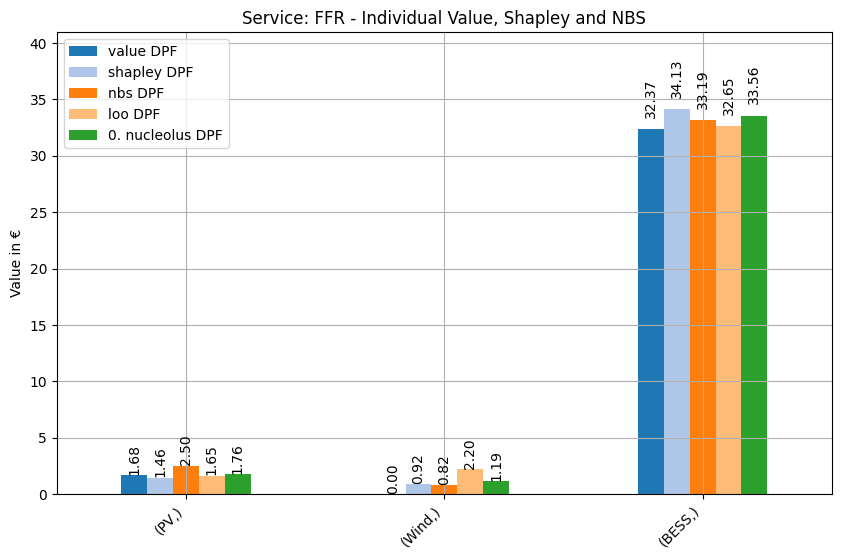

Core is non-empty, one feasible allocation: [ 1.849698  2.292049 32.369   ]


<Figure size 640x480 with 0 Axes>

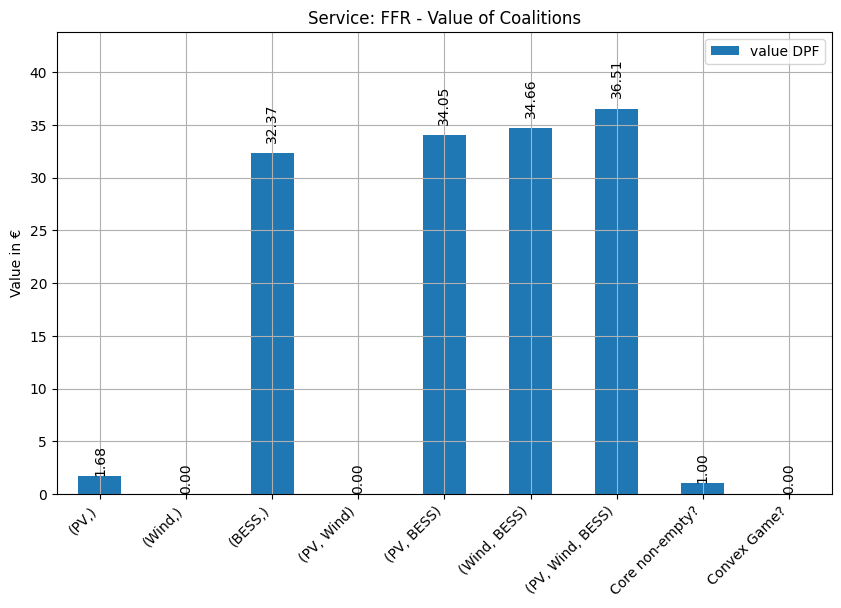

<Figure size 640x480 with 0 Axes>

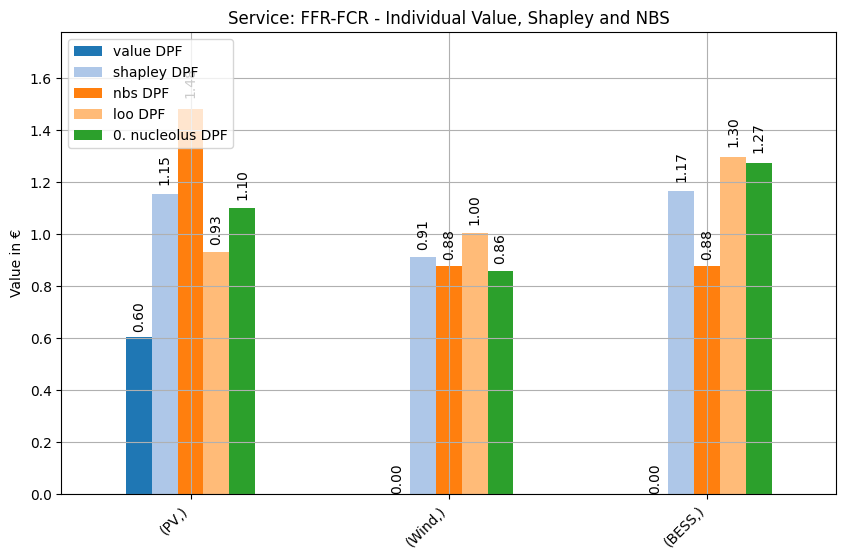

Core is non-empty, one feasible allocation: [1.595987 1.638574 0.      ]


<Figure size 640x480 with 0 Axes>

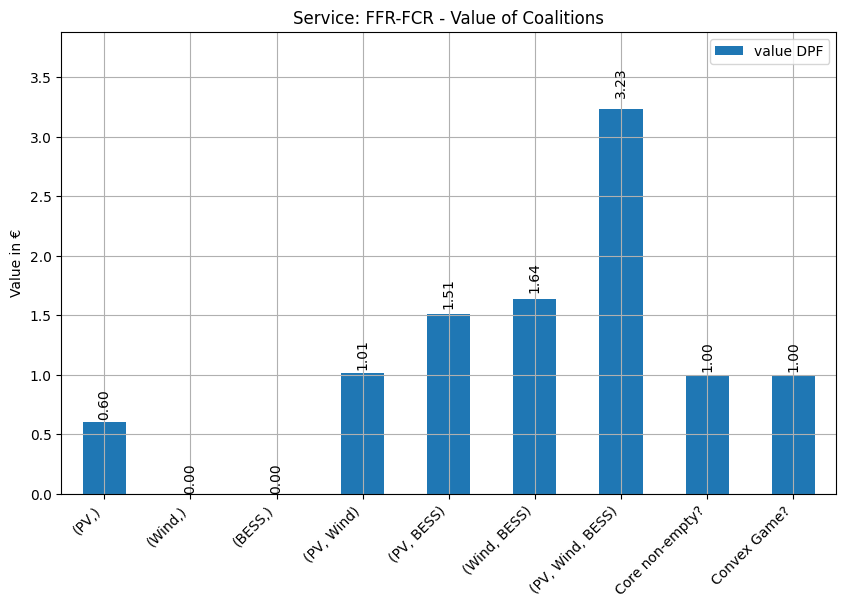

In [19]:
visualize_value_results(df_rewards_forecast, None)

## reward splitting with 2-step process

In [20]:
# 1. step: every player gets the df_forecast value, the expected reward
df_step1 = add_reward_mechanisms(df_forecast, players)
df_step1

Core is non-empty, one feasible allocation: [1.652604 1.707707 0.      ]
Core is non-empty, one feasible allocation: [1.689059 1.734126 0.      ]
Core is non-empty, one feasible allocation: [ 1.849698  2.292049 32.369   ]
Core is non-empty, one feasible allocation: [1.595987 1.638574 0.      ]


(PV,)   (Wind,)    (BESS,) (PV, Wind) (PV, BESS)  \
Service                                                                     
FCR     value         1.582561  1.670425    -1.7187   3.297437   1.592698   
        shapley       1.901457  2.002893  -0.544039       <NA>       <NA>   
        nbs           2.191236    2.2791  -1.110025       <NA>       <NA>   
FCR-D   value         1.612379  1.734126    -1.7187   3.423185   1.623371   
        shapley       1.939001  2.055252  -0.571068       <NA>       <NA>   
        nbs           2.210839  2.332586   -1.12024       <NA>       <NA>   
FFR     value         1.676688 -6.460167     32.369  -1.170124  34.048053   
        shapley       2.336978 -1.424951   35.59872       <NA>       <NA>   
        nbs           4.651763 -3.485092  35.344075       <NA>       <NA>   
FFR-FCR value          0.60478 -0.662996    -1.7187    1.01245   1.513976   
        shapley       1.551609   0.98002   0.702931       <NA>       <NA>   
        nbs           2.275272  1.007496  -0.048208       <NA>       <NA>   
FCR     0. nucleolus  1.617583  1.723734   0.018995        NaN        NaN   
FCR-D   0. nucleolus  1.667163  1.777918  -0.021896        NaN        NaN   
FFR     0. nucleolus  1.763193 -0.277382  35.024935        NaN        NaN   
FFR-FCR 0. nucleolus  1.100384  0.816326   1.317852        NaN        NaN   

                     (Wind, BESS) (PV, Wind, BESS)  
Service                                             
FCR     value            1.707707         3.360311  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
FCR-D   value            1.734126         3.423185  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
FFR     value           34.661049        36.510747  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
FFR-FCR value            1.638574         3.234561  
        shapley              <NA>             <NA>  
        nbs                  <NA>             <NA>  
FCR     0. nucleolus          NaN              NaN  
FCR-D   0. nucleolus          NaN              NaN  
FFR     0. nucleolus          NaN              NaN  
FFR-FCR 0. nucleolus          NaN              NaN

In [66]:
# 2. step: the real reward may be  different then the forecasted reward. thus, we compute the difference and split it again
grand_coalition = tuple(players)
diff = df_forecast[grand_coalition] - df_real[grand_coalition]
print(f"Difference that has to be subtracted from forecasted values: {diff}")

Difference that has to be subtracted from forecasted values: Service
FCR        0.160748
FCR-D      0.122285
FFR        0.776060
FFR-FCR    0.161402
Name: (PV, Wind, BESS), dtype: float64


In [67]:
def get_values_bankrupcy(E, ds, players):
    v = {frozenset(): 0}
    for coalition in powerset(players):
        base_val = E
        for p in frozenset(players) - coalition:
            base_val -= ds[p]
        v[frozenset(coalition)] = max(0, base_val)
    v[frozenset()] = 0
    return v

In [68]:
df_forecasts = add_reward_mechanisms(df_forecast, players)

Core is non-empty, one feasible allocation: [1.652604 1.707707 0.      ]
Core is non-empty, one feasible allocation: [1.689059 1.734126 0.      ]
Core is non-empty, one feasible allocation: [ 1.849698  2.292049 32.369   ]
Core is non-empty, one feasible allocation: [1.595987 1.638574 0.      ]


In [69]:
# create bankrupcy game
# get claims of players for each sharing method
df_forecast[df_forecast < 0] = 0
# add reward mechanisms
df_forecasts = add_reward_mechanisms(df_forecast, players)

final_allocation = {}

for service in df_forecast.index:
    total_reward = df_real[tuple(players)][service]
    for method in df_forecasts.loc[service].index:
        # get claims for each sharing method
        if method=='value': continue
        claims = df_forecasts.loc[service].loc[method]
        ds = {k[0]: v for k, v in claims.items() if len(k)==1}
        # print(f'{service} - {method}: total reward={total_reward}, claims={ds}')
        vs = get_values_bankrupcy(total_reward, ds=ds, players=players)
        print(f'{service} - {method}: {core_nonempty(vs, players)}')
        # get new allocation method
        x = pd.DataFrame(index=vs.keys(), data=vs.values()).T
        x = add_reward_mechanisms(x, players)
        final_allocation[(service, method)] = x

Core is non-empty, one feasible allocation: [1.652604 1.707707 0.      ]
Core is non-empty, one feasible allocation: [1.689059 1.734126 0.      ]
Core is non-empty, one feasible allocation: [ 1.849698  2.292049 32.369   ]
Core is non-empty, one feasible allocation: [1.595987 1.638574 0.      ]
Core is non-empty, one feasible allocation: [1.61500667 1.58455633 0.        ]
FCR - shapley: True
Core is non-empty, one feasible allocation: [1.61500667 1.58455633 0.        ]
Core is non-empty, one feasible allocation: [1.618336 1.581227 0.      ]
FCR - nbs: True
Core is non-empty, one feasible allocation: [1.618336 1.581227 0.      ]
Core is non-empty, one feasible allocation: [1.6175825 1.5819805 0.       ]
FCR - 0. nucleolus: True
Core is non-empty, one feasible allocation: [1.6175825 1.5819805 0.       ]
Core is non-empty, one feasible allocation: [1.652551 1.648349 0.      ]
FCR-D - shapley: True
Core is non-empty, one feasible allocation: [1.652551 1.648349 0.      ]
Core is non-empty, o

In [70]:
final_allocation.keys()

dict_keys([('FCR', 'shapley'), ('FCR', 'nbs'), ('FCR', '0. nucleolus'), ('FCR-D', 'shapley'), ('FCR-D', 'nbs'), ('FCR-D', '0. nucleolus'), ('FFR', 'shapley'), ('FFR', 'nbs'), ('FFR', '0. nucleolus'), ('FFR-FCR', 'shapley'), ('FFR-FCR', 'nbs'), ('FFR-FCR', '0. nucleolus')])

<Figure size 640x480 with 0 Axes>

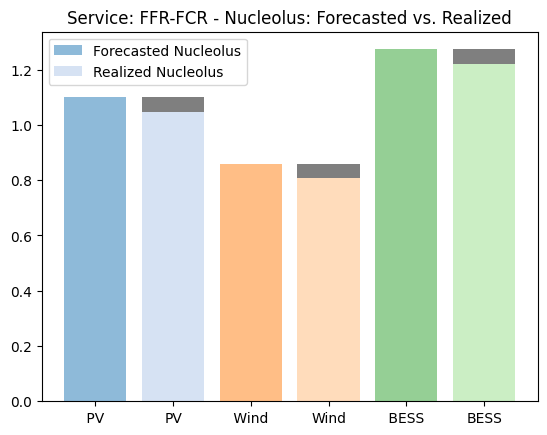

<Figure size 640x480 with 0 Axes>

In [119]:
# visualize nucleolus final allocation vs. forecasted nucleolus
# take one key
key = ('FFR-FCR', '0. nucleolus')
col = (0, '0. nucleolus')
r = final_allocation[key].loc[col]
f = df_rewards_forecast.loc[key[0]].loc[key[1]] # get foreacasted nucleolus
# get non na index
r = r.dropna()
f = f.dropna()
# plot forecasts vs. realized
plt.figure()
for i, idx in enumerate(r.index):
    label = idx[0]
    if i==0:
        plt.bar(' ' + label + ' ', f[idx], alpha=0.5, label='Forecasted Nucleolus')
        plt.bar(label, r[idx], alpha=0.5, label='Realized Nucleolus') 
        plt.bar(label, f[idx]-r[idx], bottom=r[idx], color='black', alpha=0.5)
    else:
        plt.bar(' ' + label + ' ', f[idx], alpha=0.5)
        plt.bar(label, r[idx], alpha=0.5)
        # add diference bar with text
        diff = f[idx]-r[idx]
        plt.bar(label, diff, bottom=r[idx], color='black', alpha=0.5)

plt.legend()
plt.title(f'Service: {key[0]} - Nucleolus: Forecasted vs. Realized')
plt.figure()
# plt.bar(np.arange(len(r.columns)), r.loc[0], alpha=0.5, label='Realized Nucleolus')